In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os
import matplotlib.patches as mpatches
import copy

def import_from_excel(e_file, filename):
    kinase_targets = e_file['kinase target'].tolist()
    JS_scores = e_file['JS Distance Score'].tolist()
    off_targets = e_file['off-target %inhibition values'].tolist()
    mu = int(filename.split('.')[0].split('_')[-2])
    return [mu, kinase_targets, JS_scores, off_targets]


In [2]:
#PKIS2-like, decrease selectivity, far less selectivity, binary
categories = [[], [], [], [], []] #for 200, 300, 400, 500, 600i
for category in categories:
    input_data = ([],[]) #for test_results_200, 700
    temp = []
    for i in range(3):
        l = copy.deepcopy(input_data)
        temp.append(l) #for each of the three tests (A, B, C)
    for i in range(4):
        temp2 = copy.deepcopy(temp)
        category.append(temp2)#for PKIS2 A/B/C and binary

for filename in os.listdir(os.getcwd()+'/results/'):
    if filename[0] != '.' and filename[0] != "~":
        f = './results/'+str(filename)
        replicate_results = []
        
        test_round = filename.split('_')[1]
        number_of_inhibitors = int((filename.split('_')[2])[:-1])
        inhibitor_type = ('_').join((filename.split('.')[0]).split('_')[3:-3])
        
        #print(test_round, number_of_inhibitors, inhibitor_type)
        
        inhibitor_map = [200, 300, 400, 500, 600]
        inhibitor_type_map = ['kinases', 
                              'kinases_nonspecific',
                              'kinases_very_nonspecific',
                              'kinases_binary2']
        test_round_map = ['A','B','C']
        
        u = inhibitor_map.index(number_of_inhibitors)
        y = inhibitor_type_map.index(inhibitor_type)
        z = test_round_map.index(test_round)
        
        #u = 0 #200
        #y = 3 #binary
        #z = 2 #testc
        
        for x in range(1,4):
            open_file = pd.read_excel(f, str(x))
            inhibitor_combination = import_from_excel(open_file, filename)
            replicate_results.append((x,inhibitor_combination))
        if replicate_results[0][1][0] == 200:
            categories[u][y][z][0].append(replicate_results)
        elif replicate_results[0][1][0] == 700:
            categories[u][y][z][1].append(replicate_results)

        
#PKIS2_data=pd.read_excel("./PKIS2/PKIS2_dataset.xlsx")
#all_kinase_names = list(PKIS2_data.columns.values)[7:]

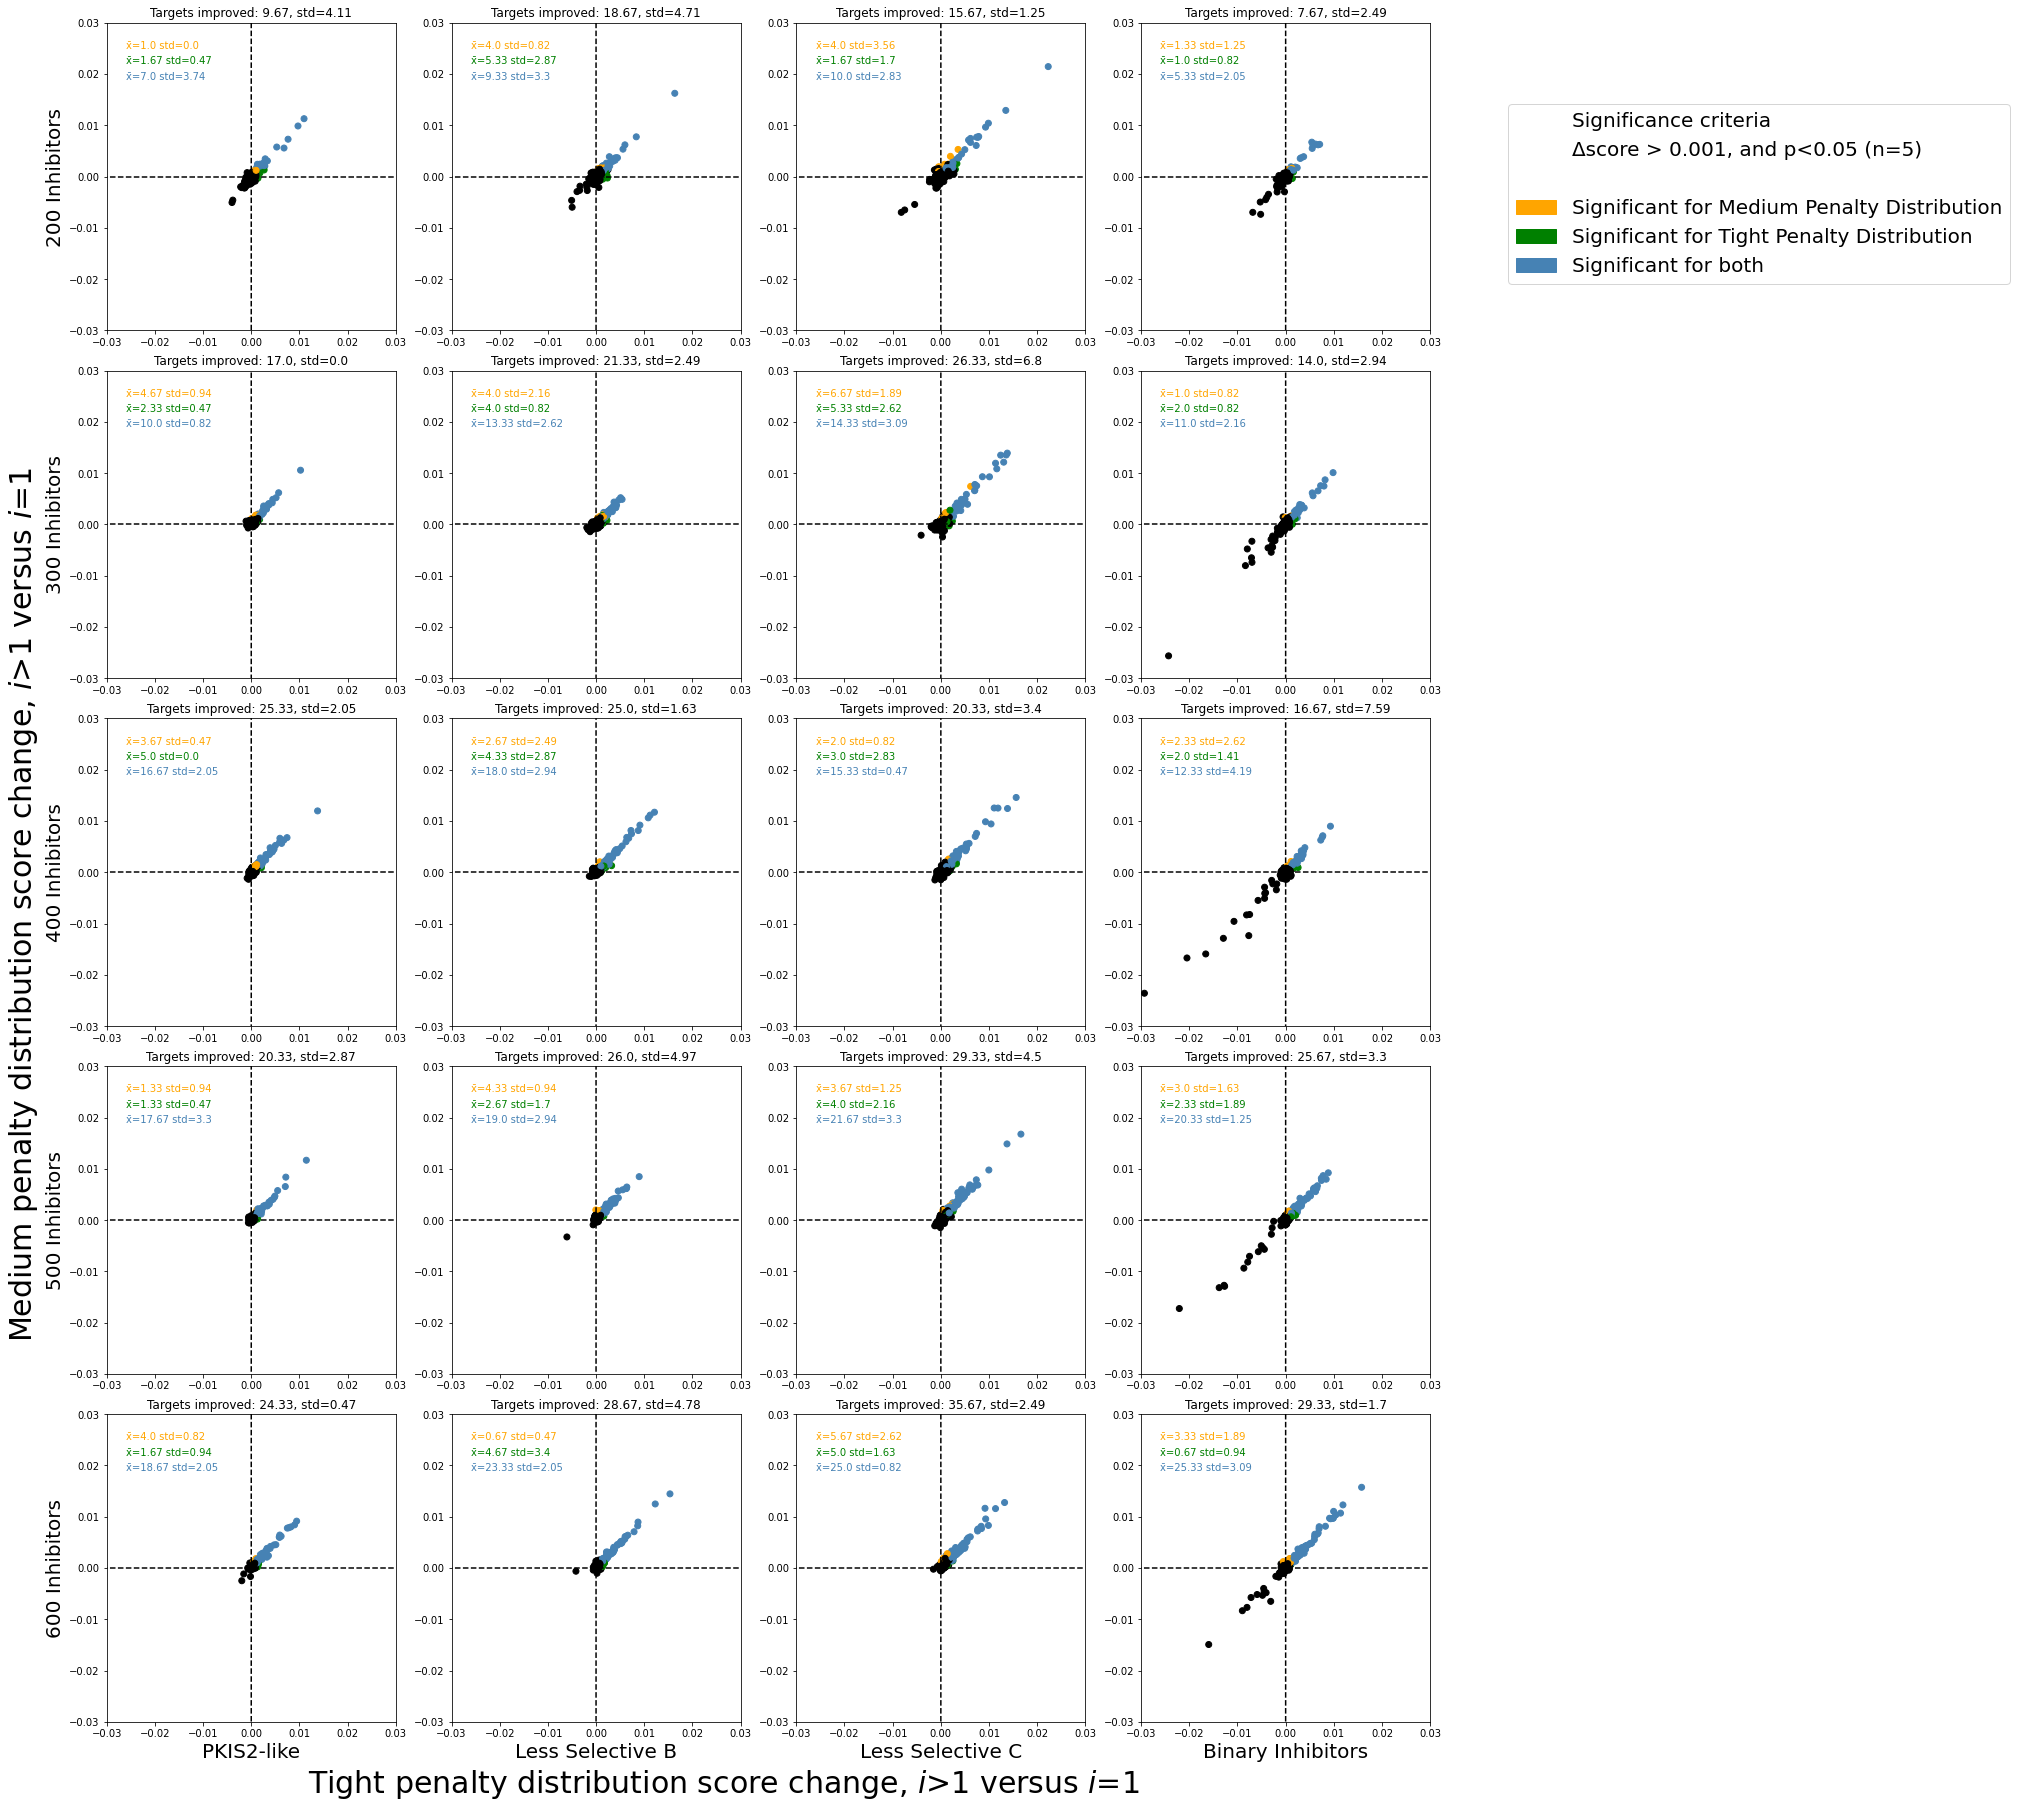

In [3]:
#Determine the total number of plots to make (row, col)
num_row = 5
num_col = 4

fig, axes = plt.subplots(num_row, num_col, figsize=(20,25),constrained_layout=True)

fig.supxlabel('Tight penalty distribution score change, $\mathregular{\mathit{i}}$>1 versus $\mathregular{\mathit{i}}$=1', fontsize=30)
fig.supylabel('Medium penalty distribution score change, $\mathregular{\mathit{i}}$>1 versus $\mathregular{\mathit{i}}$=1', fontsize=30)

u700ldg = mpatches.Patch(color='orange', label='Significant for Medium Penalty Distribution')
u200ldg = mpatches.Patch(color='green', label='Significant for Tight Penalty Distribution')
bothldg = mpatches.Patch(color='steelblue', label='Significant for both')

s1 = mpatches.Patch(color='none', label='Significance criteria')
s2 = mpatches.Patch(color='none', label='Δscore > 0.001, and p<0.05 (n=5)')
spacer = mpatches.Patch(color='none', label='')

fig.legend(handles=[s1,s2,spacer,u700ldg, u200ldg, bothldg],bbox_to_anchor=(1.4, 0.95),fontsize=20)

axes[4][0].set_xlabel('PKIS2-like', fontsize=20)
axes[4][1].set_xlabel('Less Selective B', fontsize=20)
axes[4][2].set_xlabel('Less Selective C', fontsize=20)
axes[4][3].set_xlabel('Binary Inhibitors', fontsize=20)

#make a data structure to hold off-target counts for a later figure

off_target_effects_200 = []
off_target_effects_700 = []

for row in range(0, num_row):
    
    n_inhib = (row*100)+200
    axes[row][0].set_ylabel(str(n_inhib)+' Inhibitors',fontsize=20)
    
    off_target_effects_200.append([])
    off_target_effects_700.append([])
    
    for col in range(0, num_col):
        
        temp = np.arange(-1,1,0.001)
        zeros =temp*0
        axes[row][col].plot(temp,zeros,'k--')
        axes[row][col].plot(zeros,temp,'k--')
        
        nsig_700 = []
        nsig_200 = []
        nsig_both = []
        
        JSD_changes_200 = []
        JSD_changes_700 = []
        
        i1_mu200_values = []
        i1_mu700_values = []
        
        off_target_effects_200[row].append(([],[]))
        off_target_effects_700[row].append(([],[]))

        for test_val in range(0, 3):
            
            test_results_200 = categories[row][col][test_val][0]
            test_results_700 = categories[row][col][test_val][1]
            
            if test_results_200 != [] and test_results_700 != []:
                
                #print(row,col,test_val)
                
                max_inhib_num = len(test_results_200[0])
                #for each kinase, get the set of scores at i=1, i=2, i=3 etc
                organized_results_200 = {}
                organized_results_700 = {}

                for replicate_200 in test_results_200:    #in each of the 5 test replicates
                    for individual_result in replicate_200:    #for each combination
                        inhibitor_combination_number = individual_result[0]     
                        k_names = individual_result[1][1]
                        JS_scores = individual_result[1][2]
                        for i in range(0, len(k_names)):
                            if k_names[i] not in organized_results_200:
                                organized_results_200[k_names[i]] = [[] for x in range(0,max_inhib_num)]
                            organized_results_200[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])

                for replicate_700 in test_results_700:    #in each of the 5 test replicates
                    for individual_result in replicate_700:    #for each combination
                        inhibitor_combination_number = individual_result[0]     
                        k_names = individual_result[1][1]
                        JS_scores = individual_result[1][2]
                        for i in range(0, len(k_names)):
                            if k_names[i] not in organized_results_700:
                                organized_results_700[k_names[i]] = [[] for x in range(0,max_inhib_num)]
                            organized_results_700[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])

                #determine which condition has the maximum mean score, what the difference is from the i=1 mean score, 
                #and if that difference is significant or not

                x_200_scored_kinase_names = []
                x_200_values = []
                x_sig = []
                max_200_vals = []
                stdevs_200 = [] #the std of the differences from i=1 to i>1 if i>1 is greater
                JSD_200_i1_scores = [] #the raw scores
                JSD_200_max_scores = [] #the raw scores

                y_700_scored_kinase_names = []
                y_700_values = []
                y_sig = []
                max_700_vals = []
                stdevs_700 = [] #the std of the differences from i=1 to i>1 if i>1 is greater
                JSD_700_i1_scores = [] #the raw scores
                JSD_700_max_scores = [] #the raw scores

                for kinase in organized_results_200:
                    #get the i=1 conition
                    i1_mean = np.mean(organized_results_200[kinase][0])
                    i1_values = organized_results_200[kinase][0]
                    max_other_combination = 0
                    max_other_combination_values = []
                    significant = 0
                    max_i_number = 0
                    #compare to higher combination #s
                    for j in range(1, max_inhib_num):
                        if organized_results_200[kinase][j] != []:
                            i_combo_mean = np.mean(organized_results_200[kinase][j])
                            if i_combo_mean > max_other_combination:
                                max_other_combination = i_combo_mean
                                max_other_combination_values = organized_results_200[kinase][j]
                                max_i_number = j
                    if max_other_combination_values != []:
                        max_200_vals.append(max_other_combination)
                        differences = [max_other_combination_values[x] - i1_values[x] for x in range(0,len(i1_values))]
                        stdev = np.std(differences)
                        stdevs_200.append(stdev)
                        #is the difference significant?
                        tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
                        if (pval < 0.05) and (np.mean(max_other_combination_values) > (i1_mean + 0.001)):
                            significant = 1
                        JS_score_difference = max_other_combination - i1_mean
                        x_200_scored_kinase_names.append(kinase)
                        x_200_values.append(JS_score_difference)
                        x_sig.append(significant)
                        JSD_200_i1_scores.append(i1_values)
                        JSD_200_max_scores.append(max_other_combination_values)
                        
                        #if the difference is significant, keep track of the off-target effects to build the next figure
                        if significant == 1:
                            for replicate_200 in test_results_200:
                                for k_temp in replicate_200[0][1][1]:
                                    if kinase == k_temp:
                                        #get the index of the kinase at the i=1 and i>1 max conditions
                                        i1_index = replicate_200[0][1][1].index(kinase)
                                        maxi_index = replicate_200[max_i_number][1][1].index(kinase)
                                        #get the off-target values
                                        offt_i1_values = replicate_200[0][1][3][i1_index]
                                        offt_maxi_values = replicate_200[max_i_number][1][3][maxi_index]
                                        #append these values to our output data structure
                                        off_target_effects_200[row][col][0].append(offt_i1_values)
                                        off_target_effects_200[row][col][1].append(offt_maxi_values)
                            
                for kinase in organized_results_700:
                    #get the i=1 conition
                    i1_mean = np.mean(organized_results_700[kinase][0])
                    i1_values = organized_results_700[kinase][0]
                    max_other_combination = 0
                    max_other_combination_values = []
                    significant = 0
                    #compare to higher combination #s
                    for j in range(1, max_inhib_num):
                        if organized_results_700[kinase][j] != []:
                            i_combo_mean = np.mean(organized_results_700[kinase][j])
                            if i_combo_mean > max_other_combination:
                                max_other_combination = i_combo_mean
                                max_other_combination_values = organized_results_700[kinase][j]
                    if max_other_combination_values != []:
                        max_700_vals.append(max_other_combination)
                        differences = [max_other_combination_values[x] - i1_values[x] for x in range(0,len(i1_values))]
                        stdev = np.std(differences)
                        stdevs_700.append(stdev)
                        #is the difference significant?
                        tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
                        if (pval < 0.05) and (np.mean(max_other_combination_values) > (i1_mean + 0.001)):
                            significant = 2
                        JS_score_difference = max_other_combination - i1_mean
                        y_700_scored_kinase_names.append(kinase)
                        y_700_values.append(JS_score_difference)
                        y_sig.append(significant)
                        JSD_700_i1_scores.append(i1_values)
                        JSD_700_max_scores.append(max_other_combination_values)
                        
                        #if the difference is significant, keep track of the off-target effects to build the next figure
                        if significant == 2:
                            for replicate_700 in test_results_700:
                                for k_temp in replicate_700[0][1][1]:
                                    if kinase == k_temp:
                                        #get the index of the kinase at the i=1 and i>1 max conditions
                                        i1_index = replicate_700[0][1][1].index(kinase)
                                        maxi_index = replicate_700[max_i_number][1][1].index(kinase)
                                        #get the off-target values
                                        offt_i1_values = replicate_700[0][1][3][i1_index]
                                        offt_maxi_values = replicate_700[max_i_number][1][3][maxi_index]
                                        #append these values to our output data structure
                                        off_target_effects_700[row][col][0].append(offt_i1_values)
                                        off_target_effects_700[row][col][1].append(offt_maxi_values)
                        
                akn = []
                for nm in x_200_scored_kinase_names:
                    akn.append(nm)
                for nm in y_700_scored_kinase_names:
                    akn.append(nm)
                all_kinase_names = set(akn)
                
                for i1_res_200 in JSD_200_i1_scores:
                    for single_score in i1_res_200:
                        i1_mu200_values.append(single_score)
                for i1_res_700 in JSD_700_i1_scores:
                    for single_score in i1_res_700:
                        i1_mu700_values.append(single_score)
    
                #for each kinase in PKIS2, get the x_val, the y_val, the total significance

                final_kinases = []
                final_x = []
                final_y = []
                sum_sig = []

                final_std_200 = []
                final_std_700 = []

                final_JSD_200_i1 = []
                final_JSD_700_i1 = []
                final_JSD_200_max = []
                final_JSD_700_max = []

                final_JSD_200_i1_stdev = []
                final_JSD_700_i1_stdev = []
                final_JSD_200_max_stdev = []
                final_JSD_700_max_stdev = []

                for kinase_target in all_kinase_names:

                    add = True
                    x_index = None
                    y_index = None

                    if kinase_target in x_200_scored_kinase_names:
                        x_index = x_200_scored_kinase_names.index(kinase_target)
                        #final_x.append(x_200_values[x_index])
                        #if x_sig[x_index] > 0:
                        #    add=True
                        #sum_sig.append(x_sig[index])
                    #else:
                        #final_x.append(0)
                        #sum_sig.append(0)
                    if kinase_target in y_700_scored_kinase_names:
                        y_index = y_700_scored_kinase_names.index(kinase_target)
                        #if y_sig[y_index] > 0:
                        #    add = True
                        #final_y.append(y_700_values[index])
                        #sum_sig[-1] = sum_sig[-1] + y_sig[index]
                    #else:
                        #final_y.append(0)
                    if add:
                        final_x.append(x_200_values[x_index])
                        final_y.append(y_700_values[y_index])
                        sum_sig.append(x_sig[x_index]+y_sig[y_index])
                        final_kinases.append(kinase_target)
                        final_std_700.append(stdevs_700[y_index]) # the std of the differences in score
                        final_std_200.append(stdevs_200[x_index]) #the std off the differences in score

                        final_JSD_200_i1.append(np.mean(JSD_200_i1_scores[x_index]))
                        final_JSD_200_max.append(np.mean(JSD_200_max_scores[x_index]))
                        final_JSD_200_i1_stdev.append(np.std(JSD_200_i1_scores[x_index]))
                        final_JSD_200_max_stdev.append(np.std(JSD_200_max_scores[x_index]))

                        final_JSD_700_i1.append(np.mean(JSD_700_i1_scores[y_index]))
                        final_JSD_700_max.append(np.mean(JSD_700_max_scores[y_index]))
                        final_JSD_700_i1_stdev.append(np.std(JSD_700_i1_scores[y_index]))
                        final_JSD_700_max_stdev.append(np.std(JSD_700_max_scores[y_index]))
        
                #convert significane to a different color for the points
                #black = not significant
                #yellow = significant for 200 (1)
                #blue = significant for 700 (2)
                #cyan = significant for both (3)
                point_color = []
                total = 0
                ns_200 = 0
                ns_700 = 0
                ns_both = 0
                for value in sum_sig:
                    if value == 1:
                        point_color.append('green')
                        total+=1
                        ns_200 += 1
                    elif value == 2:
                        point_color.append('orange')
                        total+=1
                        ns_700+=1
                    elif value == 3:
                        point_color.append('steelblue')
                        total+=1
                        ns_both += 1
                    else:
                        point_color.append('k')
                 
                nsig_700.append(ns_700)
                nsig_200.append(ns_200)
                nsig_both.append(ns_both)
                
                axes[row][col].scatter(final_x, final_y, c=point_color)
                axes[row][col].set_xlim(-0.03,0.03)
                axes[row][col].set_ylim(-0.03,0.03)
                
                for c in range(0, len(point_color)):
                    if point_color[c] == 'green' or point_color[c] == 'steelblue':
                        JSD_changes_200.append(final_x[c])
                    if point_color[c] == 'orange' or point_color[c] == 'steelblue':
                        JSD_changes_700.append(final_y[c])
                
        allt_improved = [nsig_200[q]+nsig_700[q]+nsig_both[q] for q in range(0, len(nsig_200))]
        total_improved_mean = np.mean(allt_improved)
        #print(len(allt_improved))
        total_improved_std = np.std(allt_improved)
        
        axes[row][col].set_title('Targets improved: '+str(round(total_improved_mean,2)) + 
                                 ', std=' + str(round(total_improved_std,2)), fontsize=12)
        
        improved_200_mean = np.mean(nsig_200)
        improved_700_mean = np.mean(nsig_700)
        improved_both_mean = np.mean(nsig_both)
        
        improved_200_stdev = np.std(nsig_200)
        improved_700_stdev = np.std(nsig_700)
        improved_both_stdev = np.std(nsig_both)
        
        axes[row][col].text(-0.026,0.025,'x̄='+str(round(improved_700_mean,2))+' std='+str(round(improved_700_stdev,2)), color='orange')
        axes[row][col].text(-0.026,0.022,'x̄='+str(round(improved_200_mean,2))+' std='+str(round(improved_200_stdev,2)), color='green')
        axes[row][col].text(-0.026,0.019,'x̄='+str(round(improved_both_mean,2))+' std='+str(round(improved_both_stdev,2)), color='steelblue')        
        
        average_improvement_200 = np.mean(JSD_changes_200)
        average_improvement_700 = np.mean(JSD_changes_700)
        std_improvement_200 = np.std(JSD_changes_200)
        std_improvement_700 = np.std(JSD_changes_700)
        
        #axes[row][col].text(0.002,-0.005,'Of sig. (+)ΔJSD targets')
        
        #axes[row][col].text(0.002,-0.010,'ΔJSD μ=200')
        #axes[row][col].text(0.002,-0.013,'x̄='+str(round(average_improvement_200,6)))
        #axes[row][col].text(0.002,-0.016,'std='+str(round(std_improvement_200,6)))
        
        #axes[row][col].text(0.002,-0.020,'ΔJSD μ=700')
        #axes[row][col].text(0.002,-0.023,'x̄='+str(round(average_improvement_700,6)))
        #axes[row][col].text(0.002,-0.026,'std='+str(round(std_improvement_700,6)))
        
        #axes[row][col].text(-0.026,0.014,'i=1 scores (n=300)')
        
        avg_200 = np.mean(i1_mu200_values)
        std_200 = np.std(i1_mu200_values)
        n_200 = len(i1_mu200_values)
        avg_700 = np.mean(i1_mu700_values)
        std_700 = np.std(i1_mu700_values)
        n_700 = len(i1_mu700_values)
        #axes[row][col].text(-0.03,0.011,'μ200: '+str(round(avg_200,5)) + ' std='+str(round(std_200,5)))
        #axes[row][col].text(-0.03,0.008,'μ700: '+str(round(avg_700,5)) + ' std='+str(round(std_700,5)))
        
        #print('test type: ', str(col))
        #print('inhib #: ',str((row+2)*100))
        #print('μ200: '+str(round(avg_200,5)) + ' std='+str(round(std_200,5)))
        #print('μ700: '+str(round(avg_700,5)) + ' std='+str(round(std_700,5)))
        
#for r in off_target_effects_700:
    #for c in r:
        #print(len(c[0]),len(c[1]))
            
plt.show()

#fig.savefig("012622_Simulated_Inhibitors_JSD_700v200_scatterplot_new-colors.pdf", bbox_inches='tight',dpi=1000)

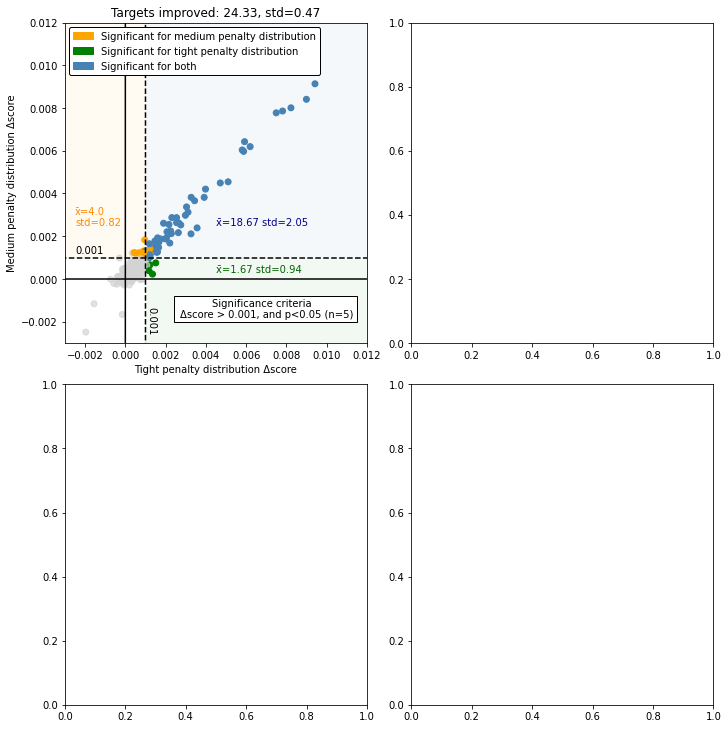

In [85]:
#just re-make the figure for PKIS2 at 600 inhibitors

#Determine the total number of plots to make (row, col)
num_row = 5
num_col = 4

fig, axes = plt.subplots(2, 2, figsize=(10,10),constrained_layout=True)

#fig.supxlabel('Tight penalty distribution score change, $\mathregular{\mathit{i}}$>1 versus $\mathregular{\mathit{i}}$=1', fontsize=30)
#fig.supylabel('Medium penalty distribution score change, $\mathregular{\mathit{i}}$>1 versus $\mathregular{\mathit{i}}$=1', fontsize=30)

u700ldg = mpatches.Patch(color='orange', label='Significant for medium penalty distribution')
u200ldg = mpatches.Patch(color='green', label='Significant for tight penalty distribution')
bothldg = mpatches.Patch(color='steelblue', label='Significant for both')

s1 = mpatches.Patch(color='none', label='Significance criteria')
s2 = mpatches.Patch(color='none', label='Δscore > 0.001, and p<0.05 (n=5)')
spacer = mpatches.Patch(color='none', label='')

fig.legend(handles=[u700ldg, u200ldg, bothldg],bbox_to_anchor=(0.445, 0.975),framealpha=1, edgecolor='k')

axes[0][0].set_xlabel('Tight penalty distribution Δscore')
axes[0][0].set_ylabel('Medium penalty distribution Δscore')

#make a data structure to hold off-target counts for a later figure

off_target_effects_200 = []
off_target_effects_700 = []

for row in range(0, 1):
    
    n_inhib = (row*100)+200
    #axes[0][0].set_ylabel(str(n_inhib)+' Inhibitors',fontsize=20)
    
    off_target_effects_200.append([])
    off_target_effects_700.append([])
    
    for col in range(0, 1):
        
        temp = np.arange(-1,1,0.001)
        zeros =temp*0
        zp1 = zeros+0.001
        axes[0][0].plot(temp,zeros, 'k')
        axes[0][0].plot(zeros,temp, 'k')
        axes[0][0].plot(temp,zp1,'k--')
        axes[0][0].plot(zp1,temp,'k--')
        
        nsig_700 = []
        nsig_200 = []
        nsig_both = []
        
        JSD_changes_200 = []
        JSD_changes_700 = []
        
        i1_mu200_values = []
        i1_mu700_values = []
        
        off_target_effects_200[0].append(([],[]))
        off_target_effects_700[0].append(([],[]))

        for test_val in range(0, 3):
            
            test_results_200 = categories[4][0][test_val][0]
            test_results_700 = categories[4][0][test_val][1]
            
            if test_results_200 != [] and test_results_700 != []:
                
                #print(row,col,test_val)
                
                max_inhib_num = len(test_results_200[0])
                #for each kinase, get the set of scores at i=1, i=2, i=3 etc
                organized_results_200 = {}
                organized_results_700 = {}

                for replicate_200 in test_results_200:    #in each of the 5 test replicates
                    for individual_result in replicate_200:    #for each combination
                        inhibitor_combination_number = individual_result[0]     
                        k_names = individual_result[1][1]
                        JS_scores = individual_result[1][2]
                        for i in range(0, len(k_names)):
                            if k_names[i] not in organized_results_200:
                                organized_results_200[k_names[i]] = [[] for x in range(0,max_inhib_num)]
                            organized_results_200[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])

                for replicate_700 in test_results_700:    #in each of the 5 test replicates
                    for individual_result in replicate_700:    #for each combination
                        inhibitor_combination_number = individual_result[0]     
                        k_names = individual_result[1][1]
                        JS_scores = individual_result[1][2]
                        for i in range(0, len(k_names)):
                            if k_names[i] not in organized_results_700:
                                organized_results_700[k_names[i]] = [[] for x in range(0,max_inhib_num)]
                            organized_results_700[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])

                #determine which condition has the maximum mean score, what the difference is from the i=1 mean score, 
                #and if that difference is significant or not

                x_200_scored_kinase_names = []
                x_200_values = []
                x_sig = []
                max_200_vals = []
                stdevs_200 = [] #the std of the differences from i=1 to i>1 if i>1 is greater
                JSD_200_i1_scores = [] #the raw scores
                JSD_200_max_scores = [] #the raw scores

                y_700_scored_kinase_names = []
                y_700_values = []
                y_sig = []
                max_700_vals = []
                stdevs_700 = [] #the std of the differences from i=1 to i>1 if i>1 is greater
                JSD_700_i1_scores = [] #the raw scores
                JSD_700_max_scores = [] #the raw scores

                for kinase in organized_results_200:
                    #get the i=1 conition
                    i1_mean = np.mean(organized_results_200[kinase][0])
                    i1_values = organized_results_200[kinase][0]
                    max_other_combination = 0
                    max_other_combination_values = []
                    significant = 0
                    max_i_number = 0
                    #compare to higher combination #s
                    for j in range(1, max_inhib_num):
                        if organized_results_200[kinase][j] != []:
                            i_combo_mean = np.mean(organized_results_200[kinase][j])
                            if i_combo_mean > max_other_combination:
                                max_other_combination = i_combo_mean
                                max_other_combination_values = organized_results_200[kinase][j]
                                max_i_number = j
                    if max_other_combination_values != []:
                        max_200_vals.append(max_other_combination)
                        differences = [max_other_combination_values[x] - i1_values[x] for x in range(0,len(i1_values))]
                        stdev = np.std(differences)
                        stdevs_200.append(stdev)
                        #is the difference significant?
                        tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
                        if (pval < 0.05) and (np.mean(max_other_combination_values) > (i1_mean + 0.001)):
                            significant = 1
                        JS_score_difference = max_other_combination - i1_mean
                        x_200_scored_kinase_names.append(kinase)
                        x_200_values.append(JS_score_difference)
                        x_sig.append(significant)
                        JSD_200_i1_scores.append(i1_values)
                        JSD_200_max_scores.append(max_other_combination_values)
                        
                        #if the difference is significant, keep track of the off-target effects to build the next figure
                        if significant == 1:
                            for replicate_200 in test_results_200:
                                for k_temp in replicate_200[0][1][1]:
                                    if kinase == k_temp:
                                        #get the index of the kinase at the i=1 and i>1 max conditions
                                        i1_index = replicate_200[0][1][1].index(kinase)
                                        maxi_index = replicate_200[max_i_number][1][1].index(kinase)
                                        #get the off-target values
                                        offt_i1_values = replicate_200[0][1][3][i1_index]
                                        offt_maxi_values = replicate_200[max_i_number][1][3][maxi_index]
                                        #append these values to our output data structure
                                        off_target_effects_200[row][col][0].append(offt_i1_values)
                                        off_target_effects_200[row][col][1].append(offt_maxi_values)
                            
                for kinase in organized_results_700:
                    #get the i=1 conition
                    i1_mean = np.mean(organized_results_700[kinase][0])
                    i1_values = organized_results_700[kinase][0]
                    max_other_combination = 0
                    max_other_combination_values = []
                    significant = 0
                    #compare to higher combination #s
                    for j in range(1, max_inhib_num):
                        if organized_results_700[kinase][j] != []:
                            i_combo_mean = np.mean(organized_results_700[kinase][j])
                            if i_combo_mean > max_other_combination:
                                max_other_combination = i_combo_mean
                                max_other_combination_values = organized_results_700[kinase][j]
                    if max_other_combination_values != []:
                        max_700_vals.append(max_other_combination)
                        differences = [max_other_combination_values[x] - i1_values[x] for x in range(0,len(i1_values))]
                        stdev = np.std(differences)
                        stdevs_700.append(stdev)
                        #is the difference significant?
                        tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
                        if (pval < 0.05) and (np.mean(max_other_combination_values) > (i1_mean + 0.001)):
                            significant = 2
                        JS_score_difference = max_other_combination - i1_mean
                        y_700_scored_kinase_names.append(kinase)
                        y_700_values.append(JS_score_difference)
                        y_sig.append(significant)
                        JSD_700_i1_scores.append(i1_values)
                        JSD_700_max_scores.append(max_other_combination_values)
                        
                        #if the difference is significant, keep track of the off-target effects to build the next figure
                        if significant == 2:
                            for replicate_700 in test_results_700:
                                for k_temp in replicate_700[0][1][1]:
                                    if kinase == k_temp:
                                        #get the index of the kinase at the i=1 and i>1 max conditions
                                        i1_index = replicate_700[0][1][1].index(kinase)
                                        maxi_index = replicate_700[max_i_number][1][1].index(kinase)
                                        #get the off-target values
                                        offt_i1_values = replicate_700[0][1][3][i1_index]
                                        offt_maxi_values = replicate_700[max_i_number][1][3][maxi_index]
                                        #append these values to our output data structure
                                        off_target_effects_700[row][col][0].append(offt_i1_values)
                                        off_target_effects_700[row][col][1].append(offt_maxi_values)
                        
                akn = []
                for nm in x_200_scored_kinase_names:
                    akn.append(nm)
                for nm in y_700_scored_kinase_names:
                    akn.append(nm)
                all_kinase_names = set(akn)
                
                for i1_res_200 in JSD_200_i1_scores:
                    for single_score in i1_res_200:
                        i1_mu200_values.append(single_score)
                for i1_res_700 in JSD_700_i1_scores:
                    for single_score in i1_res_700:
                        i1_mu700_values.append(single_score)
    
                #for each kinase in PKIS2, get the x_val, the y_val, the total significance

                final_kinases = []
                final_x = []
                final_y = []
                sum_sig = []

                final_std_200 = []
                final_std_700 = []

                final_JSD_200_i1 = []
                final_JSD_700_i1 = []
                final_JSD_200_max = []
                final_JSD_700_max = []

                final_JSD_200_i1_stdev = []
                final_JSD_700_i1_stdev = []
                final_JSD_200_max_stdev = []
                final_JSD_700_max_stdev = []

                for kinase_target in all_kinase_names:

                    add = True
                    x_index = None
                    y_index = None

                    if kinase_target in x_200_scored_kinase_names:
                        x_index = x_200_scored_kinase_names.index(kinase_target)
                    if kinase_target in y_700_scored_kinase_names:
                        y_index = y_700_scored_kinase_names.index(kinase_target)
                    if add:
                        final_x.append(x_200_values[x_index])
                        final_y.append(y_700_values[y_index])
                        sum_sig.append(x_sig[x_index]+y_sig[y_index])
                        final_kinases.append(kinase_target)
                        final_std_700.append(stdevs_700[y_index]) # the std of the differences in score
                        final_std_200.append(stdevs_200[x_index]) #the std off the differences in score

                        final_JSD_200_i1.append(np.mean(JSD_200_i1_scores[x_index]))
                        final_JSD_200_max.append(np.mean(JSD_200_max_scores[x_index]))
                        final_JSD_200_i1_stdev.append(np.std(JSD_200_i1_scores[x_index]))
                        final_JSD_200_max_stdev.append(np.std(JSD_200_max_scores[x_index]))

                        final_JSD_700_i1.append(np.mean(JSD_700_i1_scores[y_index]))
                        final_JSD_700_max.append(np.mean(JSD_700_max_scores[y_index]))
                        final_JSD_700_i1_stdev.append(np.std(JSD_700_i1_scores[y_index]))
                        final_JSD_700_max_stdev.append(np.std(JSD_700_max_scores[y_index]))
                        
                point_color = []
                alphas = []
                total = 0
                ns_200 = 0
                ns_700 = 0
                ns_both = 0
                for value in sum_sig:
                    if value == 1:
                        point_color.append('green')
                        alphas.append(1)
                        total+=1
                        ns_200 += 1
                    elif value == 2:
                        point_color.append('orange')
                        alphas.append(1)
                        total+=1
                        ns_700+=1
                    elif value == 3:
                        point_color.append('steelblue')
                        alphas.append(1)
                        total+=1
                        ns_both += 1
                    else:
                        point_color.append('lightgrey')
                        alphas.append(0.7)
                 
                nsig_700.append(ns_700)
                nsig_200.append(ns_200)
                nsig_both.append(ns_both)
                
                axes[row][col].scatter(final_x, final_y, c=point_color, alpha=alphas)
                axes[row][col].set_xlim(-0.003,0.012)
                axes[row][col].set_ylim(-0.003,0.012)
                
                for c in range(0, len(point_color)):
                    if point_color[c] == 'green' or point_color[c] == 'steelblue':
                        JSD_changes_200.append(final_x[c])
                    if point_color[c] == 'orange' or point_color[c] == 'steelblue':
                        JSD_changes_700.append(final_y[c])
                
        allt_improved = [nsig_200[q]+nsig_700[q]+nsig_both[q] for q in range(0, len(nsig_200))]
        total_improved_mean = np.mean(allt_improved)
        #print(len(allt_improved))
        total_improved_std = np.std(allt_improved)
        
        axes[row][col].set_title('Targets improved: '+str(round(total_improved_mean,2)) + 
                                 ', std=' + str(round(total_improved_std,2)), fontsize=12)
        
        improved_200_mean = np.mean(nsig_200)
        improved_700_mean = np.mean(nsig_700)
        improved_both_mean = np.mean(nsig_both)
        
        improved_200_stdev = np.std(nsig_200)
        improved_700_stdev = np.std(nsig_700)
        improved_both_stdev = np.std(nsig_both)
        
        axes[row][col].text(-0.0025,0.003,'x̄='+str(round(improved_700_mean,2)), color='darkorange')
        axes[row][col].text(-0.0025,0.0025,'std='+str(round(improved_700_stdev,2)), color='darkorange')
        axes[row][col].text(0.0045,0.0003,'x̄='+str(round(improved_200_mean,2))+' std='+str(round(improved_200_stdev,2)), color='darkgreen')
        axes[row][col].text(0.0045,0.0025,'x̄='+str(round(improved_both_mean,2))+' std='+str(round(improved_both_stdev,2)), color='darkblue')        
        
        average_improvement_200 = np.mean(JSD_changes_200)
        average_improvement_700 = np.mean(JSD_changes_700)
        std_improvement_200 = np.std(JSD_changes_200)
        std_improvement_700 = np.std(JSD_changes_700)
        
        avg_200 = np.mean(i1_mu200_values)
        std_200 = np.std(i1_mu200_values)
        n_200 = len(i1_mu200_values)
        avg_700 = np.mean(i1_mu700_values)
        std_700 = np.std(i1_mu700_values)
        n_700 = len(i1_mu700_values)
        
        axes[row][col].text(0.00105,-0.0025,'0.001', rotation=-90)
        axes[row][col].text(-0.0025,0.0012,'0.001')
        
        axes[row][col].text(0.0043,-0.0013,'Significance criteria')
        axes[row][col].text(0.0027,-0.0018,'Δscore > 0.001, and p<0.05 (n=5)')
        
        axes[row][col].fill([0.001,0.012,0.012,0.001], [0.001,0.001,.012,.012], 'steelblue', alpha=0.05)
        axes[row][col].fill([-0.02,0.001,0.001,-0.02], [0.001,0.001,.012,.012], 'orange', alpha=0.05)
        axes[row][col].fill([0.001,0.012,0.012,0.001], [-0.03,-0.03,.001,.001], 'green', alpha=0.05)
        
        xmin = 0.0024
        xmax = 0.0115
        
        ymin = -0.002
        ymax = -0.0008
        
        axes[row][col].fill([xmin,xmax,xmax,xmin], [ymin,ymin,ymax,ymax], 'white', alpha=1, edgecolor='k')
        
            
fig.savefig("013122_Simulated_Inhibitors_PKIS2-like-600i.pdf", bbox_inches='tight',dpi=1000)

In [ ]:
#what were the average i=1 scores for each condition? (copied from above output)

'''
test type:  0
inhib #:  200
μ200: 0.96435 std=0.02351
μ700: 0.96468 std=0.0234
test type:  1
inhib #:  200
μ200: 0.95506 std=0.02975
μ700: 0.95532 std=0.02969
test type:  2
inhib #:  200
μ200: 0.93445 std=0.04789
μ700: 0.93429 std=0.04783
test type:  3
inhib #:  200
μ200: 0.95934 std=0.02233
μ700: 0.95934 std=0.02225
test type:  0
inhib #:  300
μ200: 0.97241 std=0.01705
μ700: 0.97228 std=0.0171
test type:  1
inhib #:  300
μ200: 0.96469 std=0.0238
μ700: 0.96461 std=0.02385
test type:  2
inhib #:  300
μ200: 0.95696 std=0.03623
μ700: 0.95701 std=0.03612
test type:  3
inhib #:  300
μ200: 0.96468 std=0.0198
μ700: 0.96455 std=0.01982
test type:  0
inhib #:  400
μ200: 0.97618 std=0.01635
μ700: 0.97629 std=0.0163
test type:  1
inhib #:  400
μ200: 0.97266 std=0.02002
μ700: 0.97285 std=0.01993
test type:  2
inhib #:  400
μ200: 0.96556 std=0.02948
μ700: 0.96596 std=0.02931
test type:  3
inhib #:  400
μ200: 0.96956 std=0.01952
μ700: 0.96949 std=0.01952
test type:  0
inhib #:  500
μ200: 0.98052 std=0.01411
μ700: 0.98072 std=0.01407
test type:  1
inhib #:  500
μ200: 0.97924 std=0.01496
μ700: 0.97924 std=0.01501
test type:  2
inhib #:  500
μ200: 0.9687 std=0.02717
μ700: 0.9689 std=0.02704
test type:  3
inhib #:  500
μ200: 0.97304 std=0.0169
μ700: 0.973 std=0.01692
test type:  0
inhib #:  600
μ200: 0.98315 std=0.0132
μ700: 0.98285 std=0.01325
test type:  1
inhib #:  600
μ200: 0.97968 std=0.01634
μ700: 0.97973 std=0.0163
test type:  2
inhib #:  600
μ200: 0.97294 std=0.023
μ700: 0.97266 std=0.02319
test type:  3
inhib #:  600
μ200: 0.97557 std=0.01673
μ700: 0.97573 std=0.01674
'''




num replicates:  130.0  represents improvement for these many kinases:  8.666666666666666
num replicates:  220.0  represents improvement for these many kinases:  14.666666666666666
num replicates:  175.0  represents improvement for these many kinases:  11.666666666666666
num replicates:  95.0  represents improvement for these many kinases:  6.333333333333333
num replicates:  185.0  represents improvement for these many kinases:  12.333333333333334
num replicates:  260.0  represents improvement for these many kinases:  17.333333333333332
num replicates:  295.0  represents improvement for these many kinases:  19.666666666666668
num replicates:  195.0  represents improvement for these many kinases:  13.0
num replicates:  325.0  represents improvement for these many kinases:  21.666666666666668
num replicates:  335.0  represents improvement for these many kinases:  22.333333333333332
num replicates:  275.0  represents improvement for these many kinases:  18.333333333333332
num replicates: 

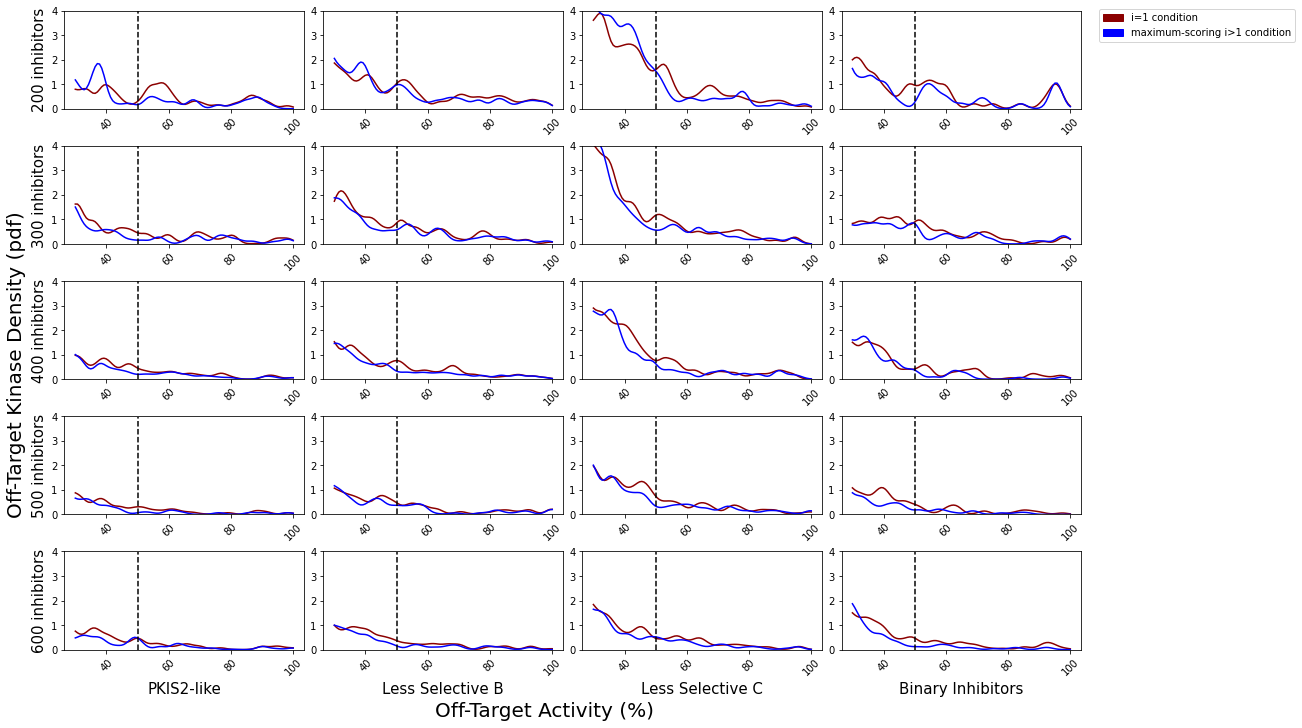

In [76]:
from scipy.stats import norm

#For each condition, get the off-targets and build plots for the actual changes in off-target effects

off_target_effects_200 = off_target_effects_200 #a reminder of the variable name

nrows = 5
ncols = 4

fig, axes = plt.subplots(nrows, ncols, figsize=(15,10),constrained_layout=True)

fig.supxlabel('Off-Target Activity (%)', fontsize=20)
fig.supylabel('Off-Target Kinase Density (pdf)', fontsize=20)

i1_patch = mpatches.Patch(color='darkred', label='i=1 condition')
max_patch = mpatches.Patch(color='b', label='maximum-scoring i>1 condition')

fig.legend(handles=[i1_patch,max_patch],bbox_to_anchor=(1.2, 1))

axes[4][0].set_xlabel('PKIS2-like',fontsize=15)
axes[4][1].set_xlabel('Less Selective B',fontsize=15)
axes[4][2].set_xlabel('Less Selective C',fontsize=15)
axes[4][3].set_xlabel('Binary Inhibitors',fontsize=15)

axes[0][0].set_ylabel('200 inhibitors',fontsize=15)
axes[1][0].set_ylabel('300 inhibitors',fontsize=15)
axes[2][0].set_ylabel('400 inhibitors',fontsize=15)
axes[3][0].set_ylabel('500 inhibitors',fontsize=15)
axes[4][0].set_ylabel('600 inhibitors',fontsize=15)

for row in range(0, nrows):
    
    for col in range(0, ncols):
        
        i1_scores = []
        i_maxx_scores = []
    
        num_r = 0
    
        for replicate in off_target_effects_200[row][col][0]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            i1_scores += vals
    
        for replicate in off_target_effects_200[row][col][1]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            i_maxx_scores += vals
            
        print('num replicates: ', (len(i1_scores)/99), 
              " represents improvement for these many kinases: ", (len(i1_scores)/99)/15)
        normfactor = (len(i1_scores)/99)/15
        
        #take avg_i1_200 and convert it into a density estimate
        x_d_1 = np.linspace(40, 100, 100)
        x_d_2 = np.linspace(40,100, 100)
        density = sum(norm(xi,scale=1.581).pdf(x_d_1)/normfactor for xi in i1_scores)
        density2 = sum(norm(xi,scale=1.581).pdf(x_d_2)/normfactor for xi in i_maxx_scores)
        
        axes[row][col].plot(x_d, density, color='darkred')
        axes[row][col].plot(x_d, density2, color='blue')
        axes[row][col].tick_params(axis='x', labelsize=10, rotation=45)
        
        ylim = max(max(density),max(density2))
        
        axes[row][col].set_ylim([0, 4])
        
        thresh1 = np.arange(0,4,0.01)
        xlim = [50]*len(thresh1)
        axes[row][col].plot(xlim,thresh1,'k--')
        
fig.savefig("012422_simulated-inhibitors-u=200.pdf", bbox_inches='tight',dpi=1000)

[0.6678805499743594, 0.0, 0.0, 0.0, 3.158557939468033, 24.472332403612917, 0.0, 0.0, 1.6869996700407508, 0.0, 22.240694439573847, 5.980780112281982, 1.9337893762757887, 18.196276835103, 2.1163583806953534, 0.0, 0.0, 0.0, 1.165310242877886, 0.0, 0.0, 0.0, 0.0, 0.0, 6.134992946723057, 5.659118321944563, 7.094357353116898, 2.200361992388602, 0.0, 0.0, 0.0, 0.0, 1.8891152580896904, 1.2864309406353442, 2.047159149111613, 2.683275839577133, 0.9853889658612687, 4.6769332459521635, 0.0, 0.0, 4.621620615678914, 0.0, 0.0, 3.0518570388318578, 0.0, 8.180652936044245, 5.200070078328515, 0.0, 0.0, 0.0, 21.83317276278235, 0.44747129101306227, 0.0, 0.0, 62.37413711808212, 44.1107919619243, 0.0, 0.0, 0.0, 1.840694463437523, 0.0, 5.162360630313091, 0.0, 6.146581258799045, 0.0, 0.133319598562342, 1.5839654614289829, 0.0, 0.0, 0.0, 0.9977281088019114, 0.0, 0.0, 0.0, 2.880980504856691, 0.0, 1.4263185905390308, 0.0, 0.0, 0.3344623225419473, 0.0, 0.0, 4.32687120181342, 1.2179904552839216, 0.0, 0.0, 0.8744623

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.69570549318958, 0.0, 0.0, 0.0, 0.0, 0.0, 36.7178167271362, 0.0, 0.0, 0.0, 22.20663018961005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.412840444202743, 14.932932329043098, 42.452866845263635, 0.0, 0.0, 0.0, 0.0, 26.02215305639249, 0.0, 0.0, 0.0, 65.29858715106465, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46.31584692856888, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 17.912104808326283, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 54.036158223578056, 0.0, 0.0, 19.58780792913732, 0.0, 0.0, 0.0, 18.266449245886072, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 25.69570549318958, 0.0, 0.0, 0.0, 0.0, 0.0, 36.7178167271362, 0.0, 0.0, 0.0, 22.20663018961005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 22.412840444202743, 14.932932329043098, 42.45

[9.888628536045447, 0.0049918627784335465, 2.084983588561719, 32.350359206354554, 1.6012997530523634, 1.9733837337427447, 5.28436022587739, 0.6677602599323496, 0.6948377200075806, 1.317694651374769, 0.965679698116958, 0.1320401491787634, 0.14804523478159878, 0.31679250769235695, 0.3403569025850898, 21.19085479901073, 3.6804183900784984, 15.593693812113244, 0.4230490452950204, 0.035962281703971005, 0.9421426700239788, 3.2494128041157646, 0.06401448684624345, 3.041386778406208, 0.06103156898005673, 1.3363313387541054, 1.1890676879785493, 1.5885512010630913, 0.05855366358309491, 0.3314139770731064, 0.4763302281404048, 0.3289540676497359, 0.38731168700404234, 0.8035475877622946, 8.754356691030997, 0.6848687807391932, 1.4373700585972753, 0.39700166431897643, 7.3864010943099565, 0.27475732040836515, 0.523546287497983, 1.7852821352651105, 1.5962972519408714, 0.9550168909954899, 0.36798045828579984, 0.6004564357155739, 3.779532124466991, 0.9440156097192173, 0.15753946678708552, 0.1198448020218

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



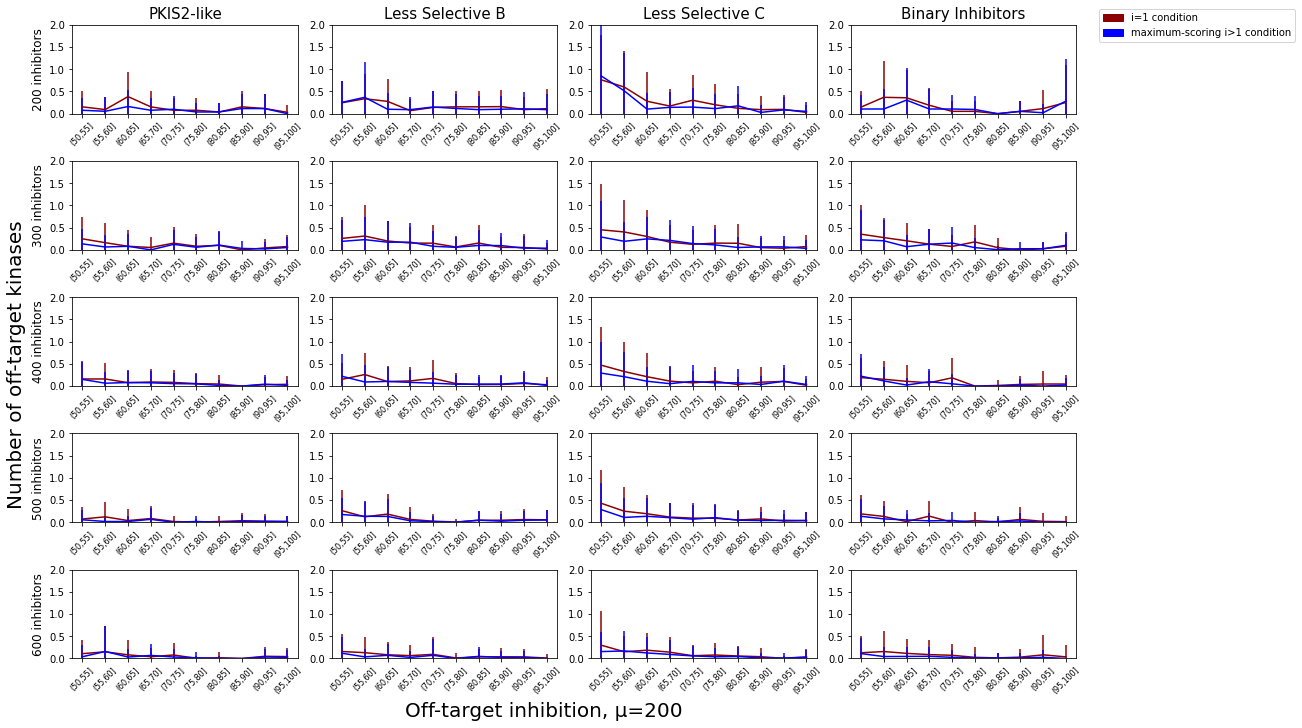

In [28]:
#For each condition, get the off-targets and build plots for the actual changes in off-target effects
#note, the number of data arrays that are used to construct the plots will vaary. Ex: for binary inhibitors
#at the 200i count, there are (on average) 6.33 significant inhibitors per analysis at the u200 condition.
#15 seperate runs were used the construct these data points (3 "biological" replicates with 5 technical replicates
#of each), so in total there are 6.33*15=95 seperate off-target distributions. The data is reported as the mean
#and std of these 15 replicates for each point, or 95 distributions (for the "aaverage" off-target distribution) 
#of a significantly enhanced point for the binary inhibitor/200i condition).


#first, aggregate the data that we already have

off_target_effects_200 = off_target_effects_200 #a reminder of the variable name

nrows = 5
ncols = 4

fig, axes = plt.subplots(nrows, ncols, figsize=(15,10),constrained_layout=True)

fig.supxlabel('Off-target inhibition, μ=200', fontsize=20)
fig.supylabel('Number of off-target kinases', fontsize=20)

i1_patch = mpatches.Patch(color='darkred', label='i=1 condition')
max_patch = mpatches.Patch(color='b', label='maximum-scoring i>1 condition')

fig.legend(handles=[i1_patch,max_patch],bbox_to_anchor=(1.2, 1))

axes[0][0].set_title('PKIS2-like',fontsize=15)
axes[0][1].set_title('Less Selective B',fontsize=15)
axes[0][2].set_title('Less Selective C',fontsize=15)
axes[0][3].set_title('Binary Inhibitors',fontsize=15)

axes[0][0].set_ylabel('200 inhibitors',fontsize=12)
axes[1][0].set_ylabel('300 inhibitors',fontsize=12)
axes[2][0].set_ylabel('400 inhibitors',fontsize=12)
axes[3][0].set_ylabel('500 inhibitors',fontsize=12)
axes[4][0].set_ylabel('600 inhibitors',fontsize=12)

for row in range(0, nrows):
    
    for col in range(0, ncols):
        
        i1_200_binned = []
    
        for replicate in off_target_effects_200[row][col][0]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            print (vals)
            bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
            for x in range(0, len(vals)): 
                temp = int(vals[x]/5)
                if temp < 20 and temp >= 0:
                    bins[temp] += 1.0
                elif temp >= 20:
                    bins[len(bins)-1] += 1.0
                else:
                    bins[0] += 1.0
            i1_200_binned.append(bins)
            
        max_200_binned = []
    
        for replicate in off_target_effects_200[row][col][1]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
            for x in range(0, len(vals)): 
                temp = int(vals[x]/5)
                if temp < 20 and temp >= 0:
                    bins[temp] += 1.0
                elif temp >= 20:
                    bins[len(bins)-1] += 1.0
                else:
                    bins[0] += 1.0
            max_200_binned.append(bins)

        
        avg_i1_200=list(np.average(i1_200_binned, axis=0))
        std_i1_200=list(np.std(i1_200_binned, axis=0))
    
        avg_max_200=list(np.average(max_200_binned, axis=0))
        std_max_200=list(np.std(max_200_binned, axis=0))
    
        bin_max = ['0','(0,5)', '(5,10]', '(10,15]', '(15,20]', '(25,30]',
               '(30,35]', '(35,40]', '(40,45]', '(45,50]', '(50,55]',
               '(55,60]', '(60,65]', '(65,70]', '(70,75]', '(75,80]',
               '(80,85]', '(85,90]', '(90,95]', '(95,100]']
    
        #only plot from 20 upwards
        bin_max_200 = bin_max[10:]
        avg_i1_200 = avg_i1_200[10:]
        std_i1_200 = std_i1_200[10:]
        avg_max_200 = avg_max_200[10:]
        std_max_200 = std_max_200[10:]
    
        ylim200_a = max(avg_i1_200)
        ylim200_b = max(avg_max_200)
        ylim_200 = max([ylim200_a,ylim200_b])
    
        axes[row][col].errorbar(bin_max_200, avg_i1_200, yerr=std_i1_200,xerr=None, color='darkred')
        axes[row][col].errorbar(bin_max_200, avg_max_200, yerr=std_max_200,xerr=None, color='blue')
        #axes[i][0].set_title(k+' '+str(round(score200,6)), x=0.5, y=1.05)
        axes[row][col].tick_params(axis='x', labelsize=8, rotation=45)
        axes[row][col].set_ylim([0,2])
    
        #add a vertical line to represent where the on-target prior becomes innefectual in either
        #thresh1 = np.arange(0,int(ylim_200*1.2),0.01)
        #xlim = [5]*len(thresh1)
        #axes[i][0].plot(xlim,thresh1,'k--')
        #axes[i][0].set_ylim((-0.2,int(ylim_200*1.2)))
    
    #axes[i][0].set_ylim(0, 10)
    #axes[i][1].set_ylim(0, 10)
        
    #now we need to 
    
#fig.savefig("121921_PKIS2_JSD_off-target-effects-u=200.pdf", bbox_inches='tight',dpi=500)

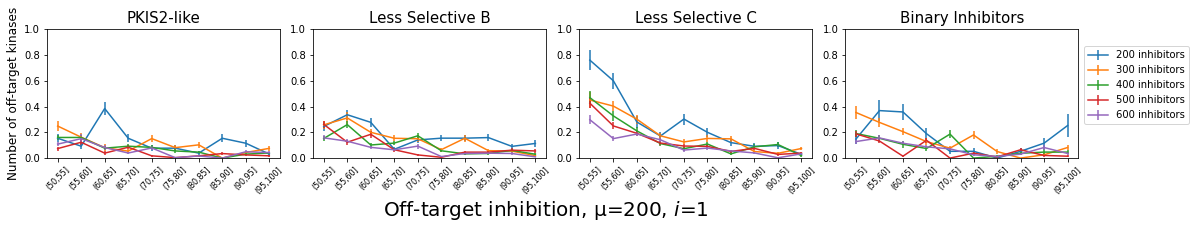

In [109]:
from scipy.stats import sem

#plot just the i=1 scores with SEM (not std) of the scores

off_target_effects_200 = off_target_effects_200 #a reminder of the variable name

nrows = 5
ncols = 4

fig, axes = plt.subplots(1, ncols, figsize=(15,3),constrained_layout=True)

axes[0].set_title('PKIS2-like',fontsize=15)
axes[1].set_title('Less Selective B',fontsize=15)
axes[2].set_title('Less Selective C',fontsize=15)
axes[3].set_title('Binary Inhibitors',fontsize=15)

fig.supxlabel('Off-target inhibition, μ=200, $\it{i}$=1', fontsize=20)
axes[0].set_ylabel('Number of off-target kinases', fontsize=12)

#axes[0][0].set_ylabel('200',fontsize=15)
#axes[1][0].set_ylabel('300',fontsize=15)
#axes[2][0].set_ylabel('400',fontsize=15)
#axes[3][0].set_ylabel('500',fontsize=15)
#axes[4][0].set_ylabel('600',fontsize=15)

for row in range(0, nrows):
    
    for col in range(0, ncols):
        
        i1_200_binned = []
    
        for replicate in off_target_effects_200[row][col][0]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
            for x in range(0, len(vals)): 
                temp = int(vals[x]/5)
                if temp < 20 and temp >= 0:
                    bins[temp] += 1.0
                elif temp >= 20:
                    bins[len(bins)-1] += 1.0
                else:
                    bins[0] += 1.0
            i1_200_binned.append(bins)
          
        '''
        max_200_binned = []
    
        for replicate in off_target_effects_200[row][col][1]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
            for x in range(0, len(vals)): 
                temp = int(vals[x]/5)
                if temp < 20 and temp >= 0:
                    bins[temp] += 1.0
                elif temp >= 20:
                    bins[len(bins)-1] += 1.0
                else:
                    bins[0] += 1.0
            max_200_binned.append(bins)
        '''

        
        avg_i1_200=list(np.average(i1_200_binned, axis=0))
        sem_i1_200=list(sem(i1_200_binned, axis=0))
    
        #avg_max_200=list(np.average(max_200_binned, axis=0))
        #std_max_200=list(np.std(max_200_binned, axis=0))
    
        bin_max = ['0','(0,5)', '(5,10]', '(10,15]', '(15,20]', '(25,30]',
               '(30,35]', '(35,40]', '(40,45]', '(45,50]', '(50,55]',
               '(55,60]', '(60,65]', '(65,70]', '(70,75]', '(75,80]',
               '(80,85]', '(85,90]', '(90,95]', '(95,100]']
    
        #only plot from 20 upwards
        bin_max_200 = bin_max[10:]
        avg_i1_200 = avg_i1_200[10:]
        sem_i1_200 = sem_i1_200[10:]
        #avg_max_200 = avg_max_200[10:]
        #std_max_200 = std_max_200[10:]
    
        ylim200_a = max(avg_i1_200)
        ylim200_b = max(avg_max_200)
        ylim_200 = max([ylim200_a,ylim200_b])
    
        axes[col].errorbar(bin_max_200, avg_i1_200, yerr=sem_i1_200,xerr=None)
        #axes[0][col].errorbar(bin_max_200, avg_max_200, yerr=std_max_200,xerr=None, color='blue')
        #axes[i][0].set_title(k+' '+str(round(score200,6)), x=0.5, y=1.05)
        axes[col].tick_params(axis='x', labelsize=8, rotation=45)
        axes[col].set_ylim([0,1])
        
fig.legend(labels=['200 inhibitors','300 inhibitors',
                   '400 inhibitors','500 inhibitors',
                   '600 inhibitors'],bbox_to_anchor=(1.1, 0.85))
        
        #thresh1 = np.arange(0,5,0.01)
        #xlim = [5]*len(thresh1)
        #axes[row][col].plot(xlim,thresh1,'k--')
    
        #add a vertical line to represent where the on-target prior becomes innefectual in either
        #thresh1 = np.arange(0,int(ylim_200*1.2),0.01)
        #xlim = [5]*len(thresh1)
        #axes[i][0].plot(xlim,thresh1,'k--')
        #axes[i][0].set_ylim((-0.2,int(ylim_200*1.2)))
    
    #axes[i][0].set_ylim(0, 10)
    #axes[i][1].set_ylim(0, 10)
        
    #now we need to 
    
#fig.savefig("121921_PKIS2_JSD_700v200_best_i1_offtarget_profiles_u=200.pdf", bbox_inches='tight',dpi=500)

num replicates:  120.0  represents improvement for these many kinases:  8.0
num replicates:  200.0  represents improvement for these many kinases:  13.333333333333334
num replicates:  210.0  represents improvement for these many kinases:  14.0
num replicates:  100.0  represents improvement for these many kinases:  6.666666666666667
num replicates:  220.0  represents improvement for these many kinases:  14.666666666666666
num replicates:  260.0  represents improvement for these many kinases:  17.333333333333332
num replicates:  315.0  represents improvement for these many kinases:  21.0
num replicates:  180.0  represents improvement for these many kinases:  12.0
num replicates:  305.0  represents improvement for these many kinases:  20.333333333333332
num replicates:  310.0  represents improvement for these many kinases:  20.666666666666668
num replicates:  260.0  represents improvement for these many kinases:  17.333333333333332
num replicates:  220.0  represents improvement for these 

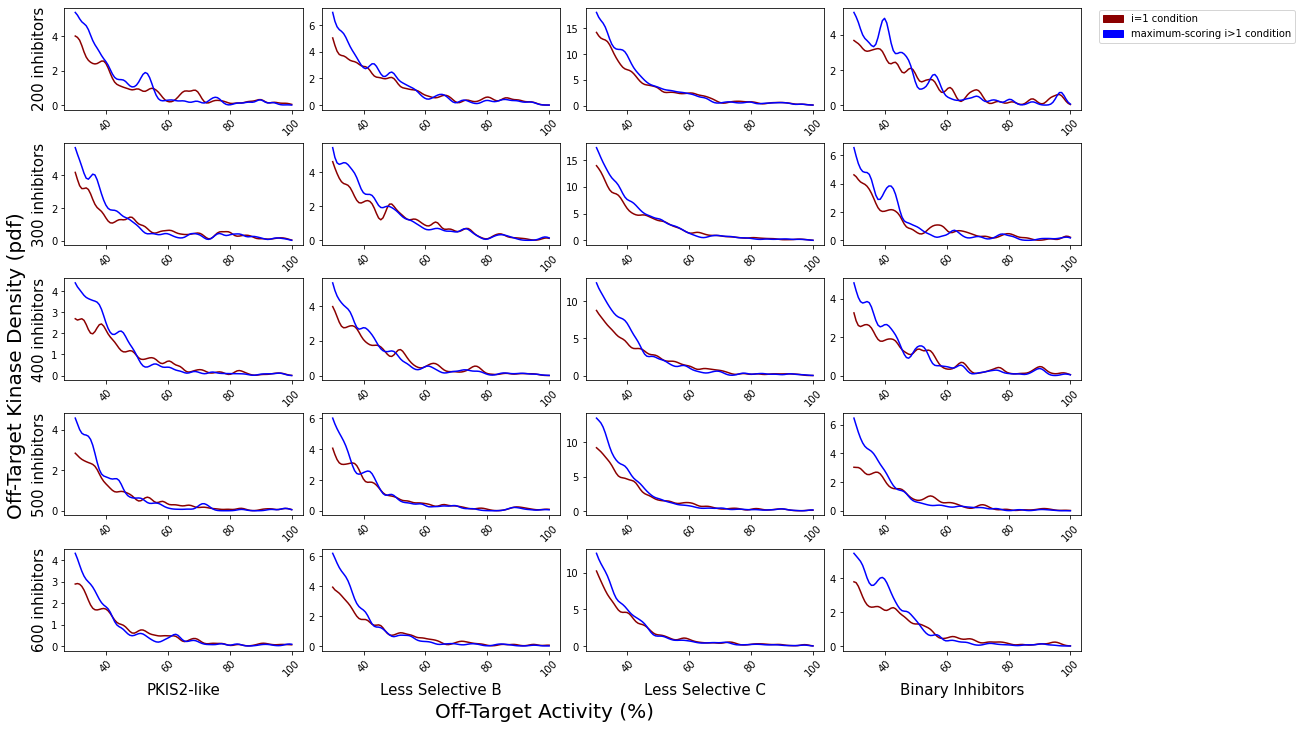

In [67]:
from scipy.stats import norm

#For each condition, get the off-targets and build plots for the actual changes in off-target effects

off_target_effects_700 = off_target_effects_700 #a reminder of the variable name

nrows = 5
ncols = 4

fig, axes = plt.subplots(nrows, ncols, figsize=(15,10),constrained_layout=True)

fig.supxlabel('Off-Target Activity (%)', fontsize=20)
fig.supylabel('Off-Target Kinase Density (pdf)', fontsize=20)

i1_patch = mpatches.Patch(color='darkred', label='i=1 condition')
max_patch = mpatches.Patch(color='b', label='maximum-scoring i>1 condition')

fig.legend(handles=[i1_patch,max_patch],bbox_to_anchor=(1.2, 1))

axes[4][0].set_xlabel('PKIS2-like',fontsize=15)
axes[4][1].set_xlabel('Less Selective B',fontsize=15)
axes[4][2].set_xlabel('Less Selective C',fontsize=15)
axes[4][3].set_xlabel('Binary Inhibitors',fontsize=15)

axes[0][0].set_ylabel('200 inhibitors',fontsize=15)
axes[1][0].set_ylabel('300 inhibitors',fontsize=15)
axes[2][0].set_ylabel('400 inhibitors',fontsize=15)
axes[3][0].set_ylabel('500 inhibitors',fontsize=15)
axes[4][0].set_ylabel('600 inhibitors',fontsize=15)

for row in range(0, nrows):
    
    for col in range(0, ncols):
        
        i1_scores = []
        i_maxx_scores = []
    
        num_r = 0
    
        for replicate in off_target_effects_700[row][col][0]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            i1_scores += vals
    
        for replicate in off_target_effects_700[row][col][1]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            i_maxx_scores += vals
            
        print('num replicates: ', (len(i1_scores)/99), 
              " represents improvement for these many kinases: ", (len(i1_scores)/99)/15)
        normfactor = (len(i1_scores)/99)/15
        
        #take avg_i1_200 and convert it into a density estimate
        x_d_1 = np.linspace(20, 100, 100)
        x_d_2 = np.linspace(20,100, 100)
        density = sum(norm(xi,scale=1.581).pdf(x_d_1)/normfactor for xi in i1_scores)
        density2 = sum(norm(xi,scale=1.581).pdf(x_d_2)/normfactor for xi in i_maxx_scores)
        
        axes[row][col].plot(x_d, density, color='darkred')
        axes[row][col].plot(x_d, density2, color='blue')
        axes[row][col].tick_params(axis='x', labelsize=10, rotation=45)
        
        #ylim = max(max(density),max(density2))
        
        #thresh1 = np.arange(0,ylim,0.01)
        #xlim = [30]*len(thresh1)
        #axes[row][col].plot(xlim,thresh1,'k--')
        
fig.savefig("012422_simulated-inhibitors-u=700.pdf", bbox_inches='tight',dpi=1000)

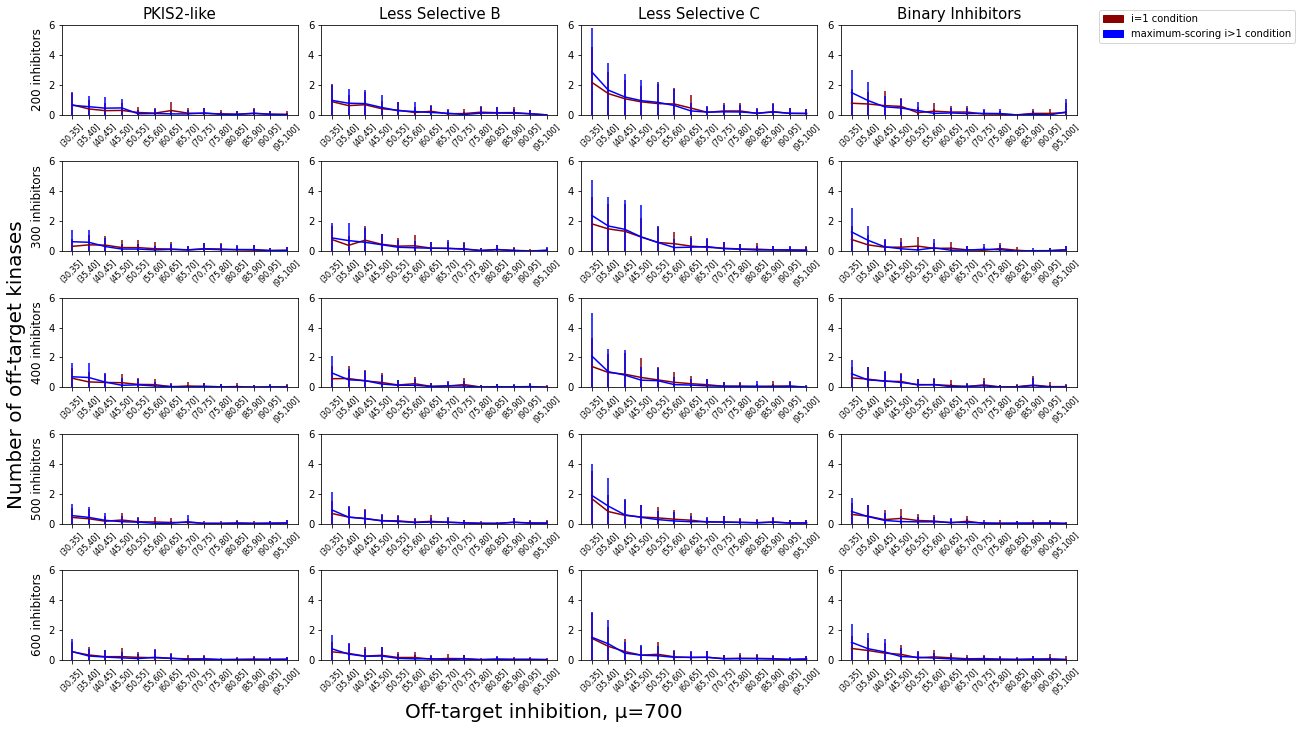

In [136]:
#For each condition, get the off-targets and build plots for the actual changes in off-target effects
#note, the number of data arrays that are used to construct the plots will vaary. Ex: for binary inhibitors
#at the 200i count, there are (on average) 6.33 significant inhibitors per analysis at the u200 condition.
#15 seperate runs were used the construct these data points (3 "biological" replicates with 5 technical replicates
#of each), so in total there are 6.33*15=95 seperate off-target distributions. The data is reported as the mean
#and std of these 15 replicates for each point, or 95 distributions (for the "aaverage" off-target distribution) 
#of a significantly enhanced point for the binary inhibitor/200i condition).


#first, aggregate the data that we already have

off_target_effects_700 = off_target_effects_700 #a reminder of the variable name

nrows = 5
ncols = 4

fig, axes = plt.subplots(nrows, ncols, figsize=(15,10),constrained_layout=True)

fig.supxlabel('Off-target inhibition, μ=700', fontsize=20)
fig.supylabel('Number of off-target kinases', fontsize=20)

i1_patch = mpatches.Patch(color='darkred', label='i=1 condition')
max_patch = mpatches.Patch(color='b', label='maximum-scoring i>1 condition')

fig.legend(handles=[i1_patch,max_patch],bbox_to_anchor=(1.2, 1))

axes[0][0].set_title('PKIS2-like',fontsize=15)
axes[0][1].set_title('Less Selective B',fontsize=15)
axes[0][2].set_title('Less Selective C',fontsize=15)
axes[0][3].set_title('Binary Inhibitors',fontsize=15)

axes[0][0].set_ylabel('200 inhibitors',fontsize=12)
axes[1][0].set_ylabel('300 inhibitors',fontsize=12)
axes[2][0].set_ylabel('400 inhibitors',fontsize=12)
axes[3][0].set_ylabel('500 inhibitors',fontsize=12)
axes[4][0].set_ylabel('600 inhibitors',fontsize=12)

for row in range(0, nrows):
    
    for col in range(0, ncols):
        
        i1_700_binned = []
    
        for replicate in off_target_effects_700[row][col][0]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
            for x in range(0, len(vals)): 
                temp = int(vals[x]/5)
                if temp < 20 and temp >= 0:
                    bins[temp] += 1.0
                elif temp >= 20:
                    bins[len(bins)-1] += 1.0
                else:
                    bins[0] += 1.0
            i1_700_binned.append(bins)
            
        max_700_binned = []
    
        for replicate in off_target_effects_700[row][col][1]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
            for x in range(0, len(vals)): 
                temp = int(vals[x]/5)
                if temp < 20 and temp >= 0:
                    bins[temp] += 1.0
                elif temp >= 20:
                    bins[len(bins)-1] += 1.0
                else:
                    bins[0] += 1.0
            max_700_binned.append(bins)

        
        avg_i1_700=list(np.average(i1_700_binned, axis=0))
        std_i1_700=list(np.std(i1_700_binned, axis=0))
    
        avg_max_700=list(np.average(max_700_binned, axis=0))
        std_max_700=list(np.std(max_700_binned, axis=0))
    
        bin_max = ['0','(0,5)', '(5,10]', '(10,15]', '(15,20]', '(25,30]',
               '(30,35]', '(35,40]', '(40,45]', '(45,50]', '(50,55]',
               '(55,60]', '(60,65]', '(65,70]', '(70,75]', '(75,80]',
               '(80,85]', '(85,90]', '(90,95]', '(95,100]']
        
        #print(avg_i1_700,std_i1_700)
    
        #only plot from 20 upwards
        bin_max_700 = bin_max[6:]
        avg_i1_700 = avg_i1_700[6:]
        std_i1_700 = std_i1_700[6:]
        avg_max_700 = avg_max_700[6:]
        std_max_700 = std_max_700[6:]
    
        ylim700_a = max(avg_i1_700)
        ylim700_b = max(avg_max_700)
        ylim_700 = max([ylim700_a,ylim700_b])
    
        axes[row][col].errorbar(bin_max_700, avg_i1_700, yerr=std_i1_700,xerr=None, color='darkred')
        axes[row][col].errorbar(bin_max_700, avg_max_700, yerr=std_max_700,xerr=None, color='blue')
        #axes[i][0].set_title(k+' '+str(round(score200,6)), x=0.5, y=1.05)
        axes[row][col].tick_params(axis='x', labelsize=8, rotation=45)
        axes[row][col].set_ylim([0,6])
    
        #add a vertical line to represent where the on-target prior becomes innefectual in either
        #thresh1 = np.arange(0,int(ylim_200*1.2),0.01)
        #xlim = [5]*len(thresh1)
        #axes[i][0].plot(xlim,thresh1,'k--')
        #axes[i][0].set_ylim((-0.2,int(ylim_200*1.2)))
    
    #axes[i][0].set_ylim(0, 10)
    #axes[i][1].set_ylim(0, 10)
        
    #now we need to 
    
#fig.savefig("121921_PKIS2_JSD_off-target-effects-u=700.pdf", bbox_inches='tight',dpi=500)

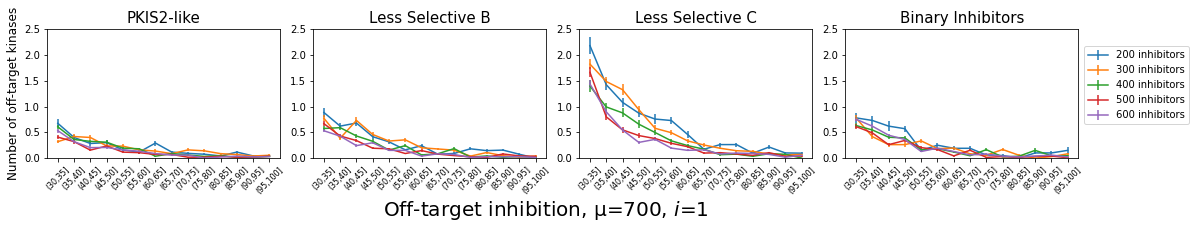

In [135]:
from scipy.stats import sem

#plot just the i=1 scores with SEM (not std) of the scores

off_target_effects_700 = off_target_effects_700 #a reminder of the variable name

nrows = 5
ncols = 4

fig, axes = plt.subplots(1, ncols, figsize=(15,3),constrained_layout=True)

axes[0].set_title('PKIS2-like',fontsize=15)
axes[1].set_title('Less Selective B',fontsize=15)
axes[2].set_title('Less Selective C',fontsize=15)
axes[3].set_title('Binary Inhibitors',fontsize=15)

fig.supxlabel('Off-target inhibition, μ=700, $\it{i}$=1', fontsize=20)
axes[0].set_ylabel('Number of off-target kinases', fontsize=12)

#axes[0][0].set_ylabel('200',fontsize=15)
#axes[1][0].set_ylabel('300',fontsize=15)
#axes[2][0].set_ylabel('400',fontsize=15)
#axes[3][0].set_ylabel('500',fontsize=15)
#axes[4][0].set_ylabel('600',fontsize=15)

for row in range(0, nrows):
    
    for col in range(0, ncols):
        
        i1_700_binned = []
    
        for replicate in off_target_effects_700[row][col][0]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
            for x in range(0, len(vals)): 
                temp = int(vals[x]/5)
                if temp < 20 and temp >= 0:
                    bins[temp] += 1.0
                elif temp >= 20:
                    bins[len(bins)-1] += 1.0
                else:
                    bins[0] += 1.0
            i1_700_binned.append(bins)
          
        '''
        max_200_binned = []
    
        for replicate in off_target_effects_200[row][col][1]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
            for x in range(0, len(vals)): 
                temp = int(vals[x]/5)
                if temp < 20 and temp >= 0:
                    bins[temp] += 1.0
                elif temp >= 20:
                    bins[len(bins)-1] += 1.0
                else:
                    bins[0] += 1.0
            max_200_binned.append(bins)
        '''

        
        avg_i1_700=list(np.average(i1_700_binned, axis=0))
        sem_i1_700=list(sem(i1_700_binned, axis=0))
    
        #avg_max_200=list(np.average(max_200_binned, axis=0))
        #std_max_200=list(np.std(max_200_binned, axis=0))
    
        bin_max = ['0','(0,5)', '(5,10]', '(10,15]', '(15,20]', '(25,30]',
               '(30,35]', '(35,40]', '(40,45]', '(45,50]', '(50,55]',
               '(55,60]', '(60,65]', '(65,70]', '(70,75]', '(75,80]',
               '(80,85]', '(85,90]', '(90,95]', '(95,100]']
    
        #only plot from 20 upwards
        bin_max_700 = bin_max[6:]
        avg_i1_700 = avg_i1_700[6:]
        sem_i1_700 = sem_i1_700[6:]
        #avg_max_200 = avg_max_200[10:]
        #std_max_200 = std_max_200[10:]
    
        ylim700_a = max(avg_i1_700)
        ylim700_b = max(avg_max_700)
        ylim_700 = max([ylim700_a,ylim700_b])
    
        axes[col].errorbar(bin_max_700, avg_i1_700, yerr=sem_i1_700,xerr=None)
        #axes[0][col].errorbar(bin_max_200, avg_max_200, yerr=std_max_200,xerr=None, color='blue')
        #axes[i][0].set_title(k+' '+str(round(score200,6)), x=0.5, y=1.05)
        axes[col].tick_params(axis='x', labelsize=8, rotation=45)
        axes[col].set_ylim([0,2.5])
        
fig.legend(labels=['200 inhibitors','300 inhibitors',
                   '400 inhibitors','500 inhibitors',
                   '600 inhibitors'],bbox_to_anchor=(1.1, 0.85))
        
        #thresh1 = np.arange(0,5,0.01)
        #xlim = [5]*len(thresh1)
        #axes[row][col].plot(xlim,thresh1,'k--')
    
        #add a vertical line to represent where the on-target prior becomes innefectual in either
        #thresh1 = np.arange(0,int(ylim_200*1.2),0.01)
        #xlim = [5]*len(thresh1)
        #axes[i][0].plot(xlim,thresh1,'k--')
        #axes[i][0].set_ylim((-0.2,int(ylim_200*1.2)))
    
    #axes[i][0].set_ylim(0, 10)
    #axes[i][1].set_ylim(0, 10)
        
    #now we need to 
    
#fig.savefig("121921_PKIS2_JSD_700v200_best_i1_offtarget_profiles_u=700.pdf", bbox_inches='tight',dpi=500)

In [ ]:
########################################################################

# REPEAT THE SAME AS ABOVE BUT USE A LARGER THRESHOLD OF 0.005, NOT 0.001

########################################################################

25 25
20 20
65 65
30 30
15 15
5 5
70 70
35 35
40 40
55 55
55 55
20 20
20 20
30 30
85 85
60 60
45 45
55 55
70 70
85 85


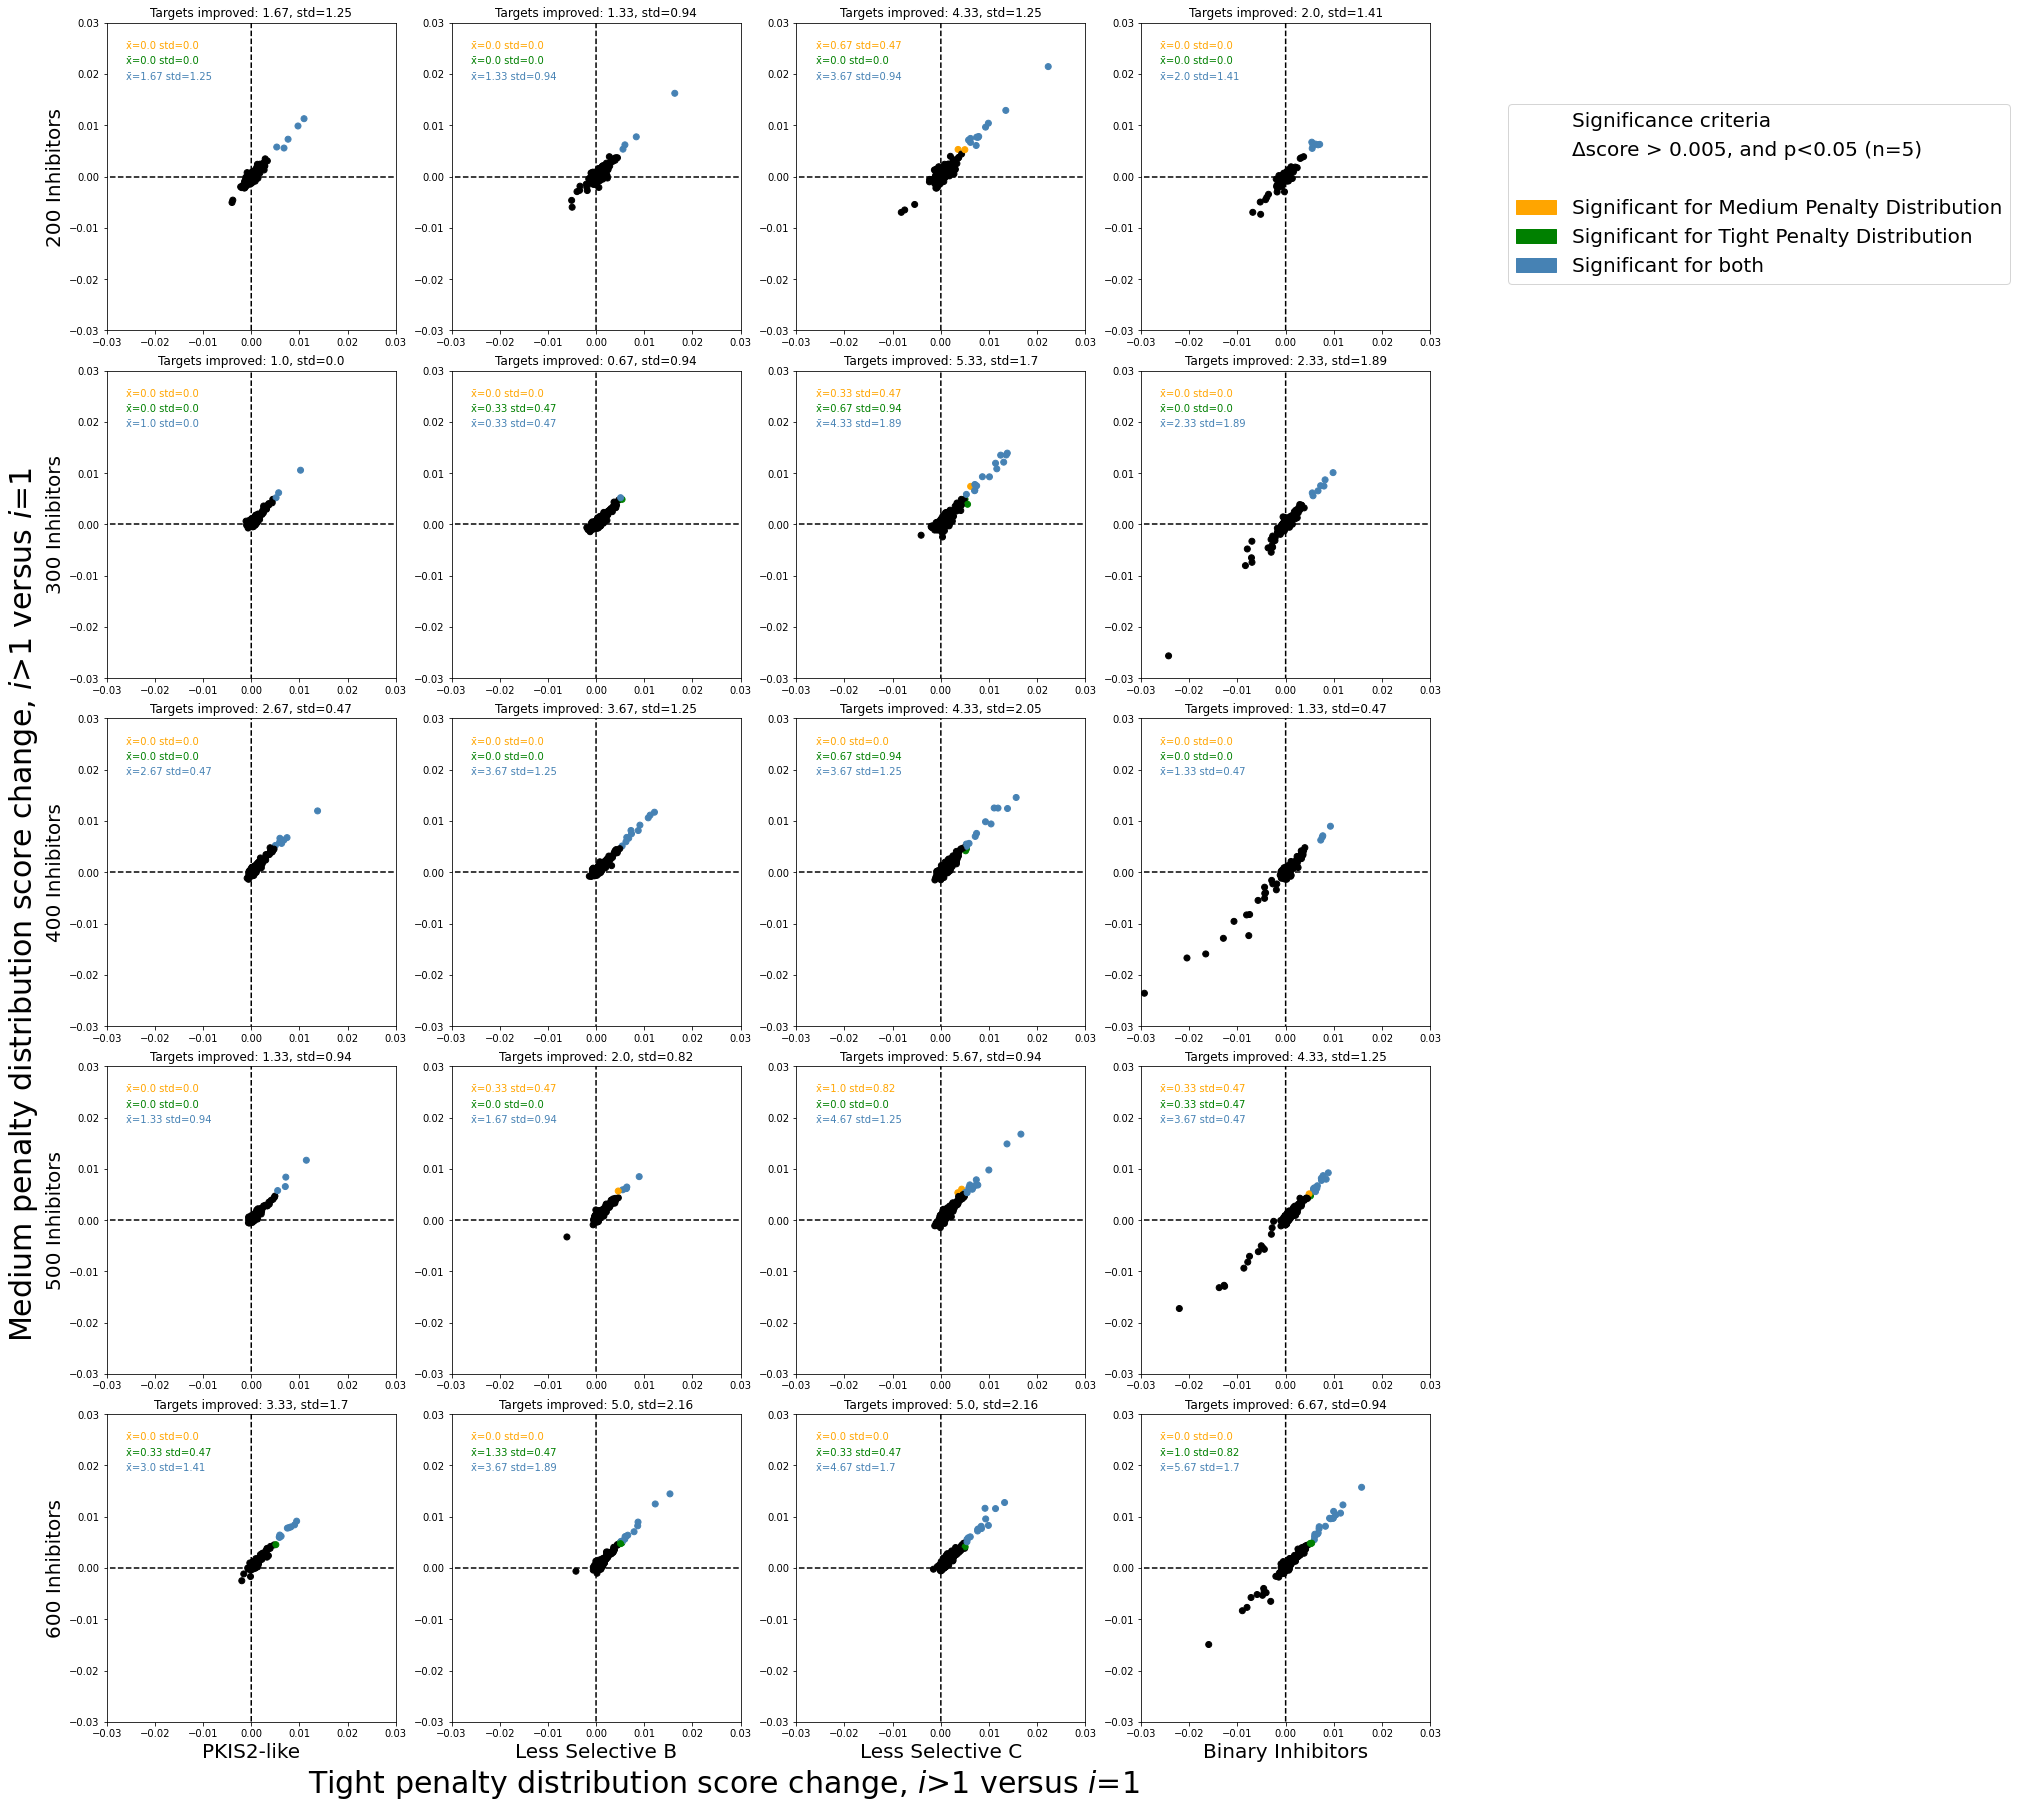

In [92]:
#Determine the total number of plots to make (row, col)
num_row = 5
num_col = 4

fig, axes = plt.subplots(num_row, num_col, figsize=(20,25),constrained_layout=True)

fig.supxlabel('Tight penalty distribution score change, $\mathregular{\mathit{i}}$>1 versus $\mathregular{\mathit{i}}$=1', fontsize=30)
fig.supylabel('Medium penalty distribution score change, $\mathregular{\mathit{i}}$>1 versus $\mathregular{\mathit{i}}$=1', fontsize=30)

u700ldg = mpatches.Patch(color='orange', label='Significant for Medium Penalty Distribution')
u200ldg = mpatches.Patch(color='green', label='Significant for Tight Penalty Distribution')
bothldg = mpatches.Patch(color='steelblue', label='Significant for both')

s1 = mpatches.Patch(color='none', label='Significance criteria')
s2 = mpatches.Patch(color='none', label='Δscore > 0.005, and p<0.05 (n=5)')
spacer = mpatches.Patch(color='none', label='')

fig.legend(handles=[s1,s2,spacer,u700ldg, u200ldg, bothldg],bbox_to_anchor=(1.4, 0.95),fontsize=20)

axes[4][0].set_xlabel('PKIS2-like', fontsize=20)
axes[4][1].set_xlabel('Less Selective B', fontsize=20)
axes[4][2].set_xlabel('Less Selective C', fontsize=20)
axes[4][3].set_xlabel('Binary Inhibitors', fontsize=20)

#make a data structure to hold off-target counts for a later figure

off_target_effects_200 = []
off_target_effects_700 = []

for row in range(0, num_row):
    
    n_inhib = (row*100)+200
    axes[row][0].set_ylabel(str(n_inhib)+' Inhibitors',fontsize=20)
    
    off_target_effects_200.append([])
    off_target_effects_700.append([])
    
    for col in range(0, num_col):
        
        temp = np.arange(-1,1,0.001)
        zeros =temp*0
        axes[row][col].plot(temp,zeros,'k--')
        axes[row][col].plot(zeros,temp,'k--')
        
        nsig_700 = []
        nsig_200 = []
        nsig_both = []
        
        JSD_changes_200 = []
        JSD_changes_700 = []
        
        i1_mu200_values = []
        i1_mu700_values = []
        
        off_target_effects_200[row].append(([],[]))
        off_target_effects_700[row].append(([],[]))

        for test_val in range(0, 3):
            
            test_results_200 = categories[row][col][test_val][0]
            test_results_700 = categories[row][col][test_val][1]
            
            if test_results_200 != [] and test_results_700 != []:
                
                #print(row,col,test_val)
                
                max_inhib_num = len(test_results_200[0])
                #for each kinase, get the set of scores at i=1, i=2, i=3 etc
                organized_results_200 = {}
                organized_results_700 = {}

                for replicate_200 in test_results_200:    #in each of the 5 test replicates
                    for individual_result in replicate_200:    #for each combination
                        inhibitor_combination_number = individual_result[0]     
                        k_names = individual_result[1][1]
                        JS_scores = individual_result[1][2]
                        for i in range(0, len(k_names)):
                            if k_names[i] not in organized_results_200:
                                organized_results_200[k_names[i]] = [[] for x in range(0,max_inhib_num)]
                            organized_results_200[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])

                for replicate_700 in test_results_700:    #in each of the 5 test replicates
                    for individual_result in replicate_700:    #for each combination
                        inhibitor_combination_number = individual_result[0]     
                        k_names = individual_result[1][1]
                        JS_scores = individual_result[1][2]
                        for i in range(0, len(k_names)):
                            if k_names[i] not in organized_results_700:
                                organized_results_700[k_names[i]] = [[] for x in range(0,max_inhib_num)]
                            organized_results_700[k_names[i]][inhibitor_combination_number-1].append(JS_scores[i])

                #determine which condition has the maximum mean score, what the difference is from the i=1 mean score, 
                #and if that difference is significant or not

                x_200_scored_kinase_names = []
                x_200_values = []
                x_sig = []
                max_200_vals = []
                stdevs_200 = [] #the std of the differences from i=1 to i>1 if i>1 is greater
                JSD_200_i1_scores = [] #the raw scores
                JSD_200_max_scores = [] #the raw scores

                y_700_scored_kinase_names = []
                y_700_values = []
                y_sig = []
                max_700_vals = []
                stdevs_700 = [] #the std of the differences from i=1 to i>1 if i>1 is greater
                JSD_700_i1_scores = [] #the raw scores
                JSD_700_max_scores = [] #the raw scores

                for kinase in organized_results_200:
                    #get the i=1 conition
                    i1_mean = np.mean(organized_results_200[kinase][0])
                    i1_values = organized_results_200[kinase][0]
                    max_other_combination = 0
                    max_other_combination_values = []
                    significant = 0
                    max_i_number = 0
                    #compare to higher combination #s
                    for j in range(1, max_inhib_num):
                        if organized_results_200[kinase][j] != []:
                            i_combo_mean = np.mean(organized_results_200[kinase][j])
                            if i_combo_mean > max_other_combination:
                                max_other_combination = i_combo_mean
                                max_other_combination_values = organized_results_200[kinase][j]
                                max_i_number = j
                    if max_other_combination_values != []:
                        max_200_vals.append(max_other_combination)
                        differences = [max_other_combination_values[x] - i1_values[x] for x in range(0,len(i1_values))]
                        stdev = np.std(differences)
                        stdevs_200.append(stdev)
                        #is the difference significant?
                        tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
                        if (pval < 0.05) and (np.mean(max_other_combination_values) > (i1_mean + 0.005)):
                            significant = 1
                        JS_score_difference = max_other_combination - i1_mean
                        x_200_scored_kinase_names.append(kinase)
                        x_200_values.append(JS_score_difference)
                        x_sig.append(significant)
                        JSD_200_i1_scores.append(i1_values)
                        JSD_200_max_scores.append(max_other_combination_values)
                        
                        #if the difference is significant, keep track of the off-target effects to build the next figure
                        if significant == 1:
                            for replicate_200 in test_results_200:
                                for k_temp in replicate_200[0][1][1]:
                                    if kinase == k_temp:
                                        #get the index of the kinase at the i=1 and i>1 max conditions
                                        i1_index = replicate_200[0][1][1].index(kinase)
                                        maxi_index = replicate_200[max_i_number][1][1].index(kinase)
                                        #get the off-target values
                                        offt_i1_values = replicate_200[0][1][3][i1_index]
                                        offt_maxi_values = replicate_200[max_i_number][1][3][maxi_index]
                                        #append these values to our output data structure
                                        off_target_effects_200[row][col][0].append(offt_i1_values)
                                        off_target_effects_200[row][col][1].append(offt_maxi_values)
                            
                for kinase in organized_results_700:
                    #get the i=1 conition
                    i1_mean = np.mean(organized_results_700[kinase][0])
                    i1_values = organized_results_700[kinase][0]
                    max_other_combination = 0
                    max_other_combination_values = []
                    significant = 0
                    #compare to higher combination #s
                    for j in range(1, max_inhib_num):
                        if organized_results_700[kinase][j] != []:
                            i_combo_mean = np.mean(organized_results_700[kinase][j])
                            if i_combo_mean > max_other_combination:
                                max_other_combination = i_combo_mean
                                max_other_combination_values = organized_results_700[kinase][j]
                    if max_other_combination_values != []:
                        max_700_vals.append(max_other_combination)
                        differences = [max_other_combination_values[x] - i1_values[x] for x in range(0,len(i1_values))]
                        stdev = np.std(differences)
                        stdevs_700.append(stdev)
                        #is the difference significant?
                        tval, pval = stats.ttest_ind(i1_values, max_other_combination_values)
                        if (pval < 0.05) and (np.mean(max_other_combination_values) > (i1_mean + 0.005)):
                            significant = 2
                        JS_score_difference = max_other_combination - i1_mean
                        y_700_scored_kinase_names.append(kinase)
                        y_700_values.append(JS_score_difference)
                        y_sig.append(significant)
                        JSD_700_i1_scores.append(i1_values)
                        JSD_700_max_scores.append(max_other_combination_values)
                        
                        #if the difference is significant, keep track of the off-target effects to build the next figure
                        if significant == 2:
                            for replicate_700 in test_results_700:
                                for k_temp in replicate_700[0][1][1]:
                                    if kinase == k_temp:
                                        #get the index of the kinase at the i=1 and i>1 max conditions
                                        i1_index = replicate_700[0][1][1].index(kinase)
                                        maxi_index = replicate_700[max_i_number][1][1].index(kinase)
                                        #get the off-target values
                                        offt_i1_values = replicate_700[0][1][3][i1_index]
                                        offt_maxi_values = replicate_700[max_i_number][1][3][maxi_index]
                                        #append these values to our output data structure
                                        off_target_effects_700[row][col][0].append(offt_i1_values)
                                        off_target_effects_700[row][col][1].append(offt_maxi_values)
                        
                akn = []
                for nm in x_200_scored_kinase_names:
                    akn.append(nm)
                for nm in y_700_scored_kinase_names:
                    akn.append(nm)
                all_kinase_names = set(akn)
                
                for i1_res_200 in JSD_200_i1_scores:
                    for single_score in i1_res_200:
                        i1_mu200_values.append(single_score)
                for i1_res_700 in JSD_700_i1_scores:
                    for single_score in i1_res_700:
                        i1_mu700_values.append(single_score)
    
                #for each kinase in PKIS2, get the x_val, the y_val, the total significance

                final_kinases = []
                final_x = []
                final_y = []
                sum_sig = []

                final_std_200 = []
                final_std_700 = []

                final_JSD_200_i1 = []
                final_JSD_700_i1 = []
                final_JSD_200_max = []
                final_JSD_700_max = []

                final_JSD_200_i1_stdev = []
                final_JSD_700_i1_stdev = []
                final_JSD_200_max_stdev = []
                final_JSD_700_max_stdev = []

                for kinase_target in all_kinase_names:

                    add = True
                    x_index = None
                    y_index = None

                    if kinase_target in x_200_scored_kinase_names:
                        x_index = x_200_scored_kinase_names.index(kinase_target)
                        #final_x.append(x_200_values[x_index])
                        #if x_sig[x_index] > 0:
                        #    add=True
                        #sum_sig.append(x_sig[index])
                    #else:
                        #final_x.append(0)
                        #sum_sig.append(0)
                    if kinase_target in y_700_scored_kinase_names:
                        y_index = y_700_scored_kinase_names.index(kinase_target)
                        #if y_sig[y_index] > 0:
                        #    add = True
                        #final_y.append(y_700_values[index])
                        #sum_sig[-1] = sum_sig[-1] + y_sig[index]
                    #else:
                        #final_y.append(0)
                    if add:
                        final_x.append(x_200_values[x_index])
                        final_y.append(y_700_values[y_index])
                        sum_sig.append(x_sig[x_index]+y_sig[y_index])
                        final_kinases.append(kinase_target)
                        final_std_700.append(stdevs_700[y_index]) # the std of the differences in score
                        final_std_200.append(stdevs_200[x_index]) #the std off the differences in score

                        final_JSD_200_i1.append(np.mean(JSD_200_i1_scores[x_index]))
                        final_JSD_200_max.append(np.mean(JSD_200_max_scores[x_index]))
                        final_JSD_200_i1_stdev.append(np.std(JSD_200_i1_scores[x_index]))
                        final_JSD_200_max_stdev.append(np.std(JSD_200_max_scores[x_index]))

                        final_JSD_700_i1.append(np.mean(JSD_700_i1_scores[y_index]))
                        final_JSD_700_max.append(np.mean(JSD_700_max_scores[y_index]))
                        final_JSD_700_i1_stdev.append(np.std(JSD_700_i1_scores[y_index]))
                        final_JSD_700_max_stdev.append(np.std(JSD_700_max_scores[y_index]))
                        
                point_color = []
                total = 0
                ns_200 = 0
                ns_700 = 0
                ns_both = 0
                for value in sum_sig:
                    if value == 1:
                        point_color.append('green')
                        total+=1
                        ns_200 += 1
                    elif value == 2:
                        point_color.append('orange')
                        total+=1
                        ns_700+=1
                    elif value == 3:
                        point_color.append('steelblue')
                        total+=1
                        ns_both += 1
                    else:
                        point_color.append('k')
                 
                nsig_700.append(ns_700)
                nsig_200.append(ns_200)
                nsig_both.append(ns_both)
                
                axes[row][col].scatter(final_x, final_y, c=point_color)
                axes[row][col].set_xlim(-0.03,0.03)
                axes[row][col].set_ylim(-0.03,0.03)
                
                for c in range(0, len(point_color)):
                    if point_color[c] == 'green' or point_color[c] == 'steelblue':
                        JSD_changes_200.append(final_x[c])
                    if point_color[c] == 'orange' or point_color[c] == 'steelblue':
                        JSD_changes_700.append(final_y[c])
                
        allt_improved = [nsig_200[q]+nsig_700[q]+nsig_both[q] for q in range(0, len(nsig_200))]
        total_improved_mean = np.mean(allt_improved)
        total_improved_std = np.std(allt_improved)
        
        axes[row][col].set_title('Targets improved: '+str(round(total_improved_mean,2)) + 
                                 ', std=' + str(round(total_improved_std,2)), fontsize=12)
        
        improved_200_mean = np.mean(nsig_200)
        improved_700_mean = np.mean(nsig_700)
        improved_both_mean = np.mean(nsig_both)
        
        improved_200_stdev = np.std(nsig_200)
        improved_700_stdev = np.std(nsig_700)
        improved_both_stdev = np.std(nsig_both)
        
        axes[row][col].text(-0.026,0.025,'x̄='+str(round(improved_700_mean,2))+' std='+str(round(improved_700_stdev,2)), color='orange')
        axes[row][col].text(-0.026,0.022,'x̄='+str(round(improved_200_mean,2))+' std='+str(round(improved_200_stdev,2)), color='green')
        axes[row][col].text(-0.026,0.019,'x̄='+str(round(improved_both_mean,2))+' std='+str(round(improved_both_stdev,2)), color='steelblue')        
        
        average_improvement_200 = np.mean(JSD_changes_200)
        average_improvement_700 = np.mean(JSD_changes_700)
        std_improvement_200 = np.std(JSD_changes_200)
        std_improvement_700 = np.std(JSD_changes_700)
        
        avg_200 = np.mean(i1_mu200_values)
        std_200 = np.std(i1_mu200_values)
        n_200 = len(i1_mu200_values)
        avg_700 = np.mean(i1_mu700_values)
        std_700 = np.std(i1_mu700_values)
        n_700 = len(i1_mu700_values)
        
for r in off_target_effects_700:
    for c in r:
        print(len(c[0]),len(c[1]))
            
plt.show()

fig.savefig("012622_Simulated_Inhibitors_JSD_700v200_scatterplot_new-colors-threshold=0.005.pdf", bbox_inches='tight',dpi=500)

num replicates:  25.0  represents improvement for these many kinases:  1.6666666666666667
num replicates:  20.0  represents improvement for these many kinases:  1.3333333333333333
num replicates:  55.0  represents improvement for these many kinases:  3.6666666666666665
num replicates:  30.0  represents improvement for these many kinases:  2.0
num replicates:  15.0  represents improvement for these many kinases:  1.0
num replicates:  10.0  represents improvement for these many kinases:  0.6666666666666666
num replicates:  75.0  represents improvement for these many kinases:  5.0
num replicates:  35.0  represents improvement for these many kinases:  2.3333333333333335
num replicates:  40.0  represents improvement for these many kinases:  2.6666666666666665
num replicates:  55.0  represents improvement for these many kinases:  3.6666666666666665
num replicates:  65.0  represents improvement for these many kinases:  4.333333333333333
num replicates:  20.0  represents improvement for these 

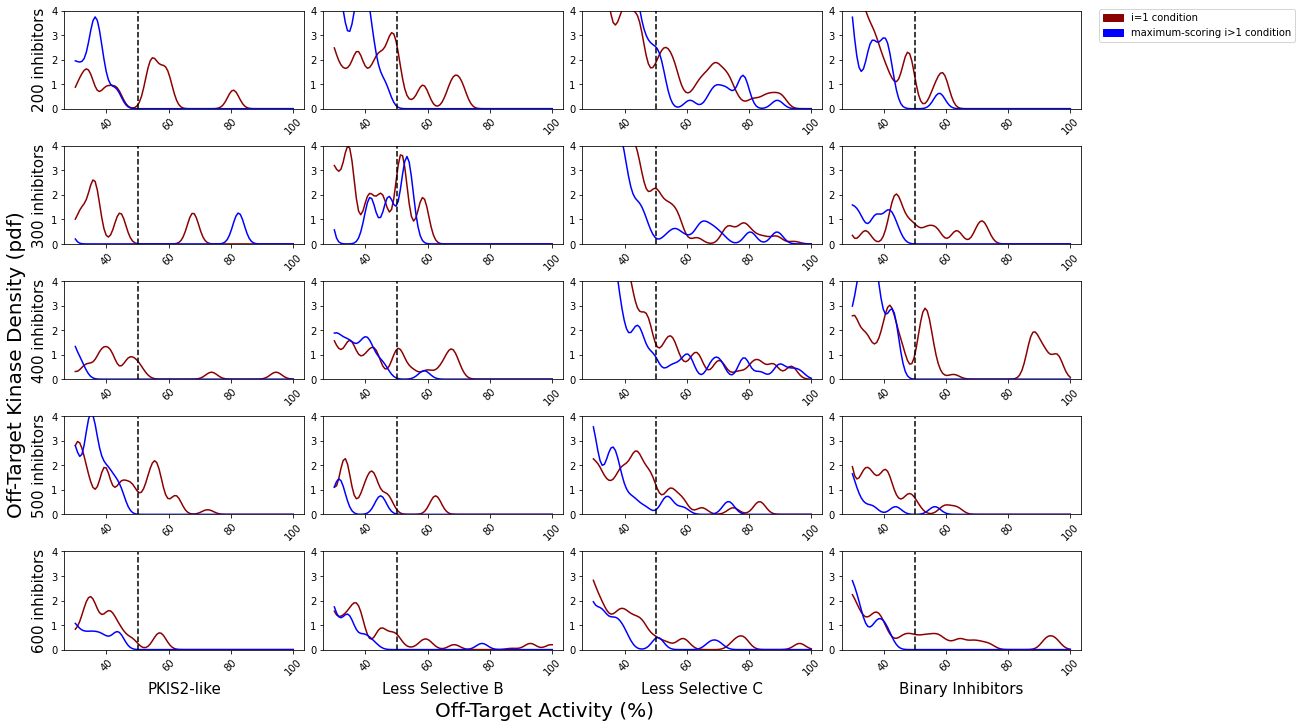

In [78]:
from scipy.stats import norm

#For each condition, get the off-targets and build plots for the actual changes in off-target effects

off_target_effects_200 = off_target_effects_200 #a reminder of the variable name

nrows = 5
ncols = 4

fig, axes = plt.subplots(nrows, ncols, figsize=(15,10),constrained_layout=True)

fig.supxlabel('Off-Target Activity (%)', fontsize=20)
fig.supylabel('Off-Target Kinase Density (pdf)', fontsize=20)

i1_patch = mpatches.Patch(color='darkred', label='i=1 condition')
max_patch = mpatches.Patch(color='b', label='maximum-scoring i>1 condition')

fig.legend(handles=[i1_patch,max_patch],bbox_to_anchor=(1.2, 1))

axes[4][0].set_xlabel('PKIS2-like',fontsize=15)
axes[4][1].set_xlabel('Less Selective B',fontsize=15)
axes[4][2].set_xlabel('Less Selective C',fontsize=15)
axes[4][3].set_xlabel('Binary Inhibitors',fontsize=15)

axes[0][0].set_ylabel('200 inhibitors',fontsize=15)
axes[1][0].set_ylabel('300 inhibitors',fontsize=15)
axes[2][0].set_ylabel('400 inhibitors',fontsize=15)
axes[3][0].set_ylabel('500 inhibitors',fontsize=15)
axes[4][0].set_ylabel('600 inhibitors',fontsize=15)

for row in range(0, nrows):
    
    for col in range(0, ncols):
        
        i1_scores = []
        i_maxx_scores = []
    
        num_r = 0
    
        for replicate in off_target_effects_200[row][col][0]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            i1_scores += vals
    
        for replicate in off_target_effects_200[row][col][1]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            i_maxx_scores += vals
            
        print('num replicates: ', (len(i1_scores)/99), 
              " represents improvement for these many kinases: ", (len(i1_scores)/99)/15)
        normfactor = (len(i1_scores)/99)/15
        
        #take avg_i1_200 and convert it into a density estimate
        x_d_1 = np.linspace(40, 100, 100)
        x_d_2 = np.linspace(40,100, 100)
        density = sum(norm(xi,scale=1.581).pdf(x_d_1)/normfactor for xi in i1_scores)
        density2 = sum(norm(xi,scale=1.581).pdf(x_d_2)/normfactor for xi in i_maxx_scores)
        
        axes[row][col].plot(x_d, density, color='darkred')
        axes[row][col].plot(x_d, density2, color='blue')
        axes[row][col].tick_params(axis='x', labelsize=10, rotation=45)
        
        #ylim = max(max(density),max(density2))
        
        axes[row][col].set_ylim([0, 4])
        
        thresh1 = np.arange(0,4,0.01)
        xlim = [50]*len(thresh1)
        axes[row][col].plot(xlim,thresh1,'k--')
        
fig.savefig("012522_simulated-inhibitors-u=200-threshold-0.005-ylim-4.pdf", bbox_inches='tight',dpi=1000)

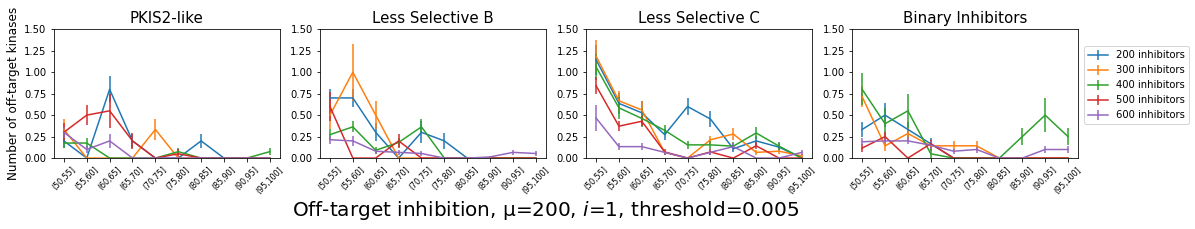

In [144]:
from scipy.stats import sem

#plot just the i=1 scores with SEM (not std) of the scores

off_target_effects_200 = off_target_effects_200 #a reminder of the variable name

nrows = 5
ncols = 4

fig, axes = plt.subplots(1, ncols, figsize=(15,3),constrained_layout=True)

axes[0].set_title('PKIS2-like',fontsize=15)
axes[1].set_title('Less Selective B',fontsize=15)
axes[2].set_title('Less Selective C',fontsize=15)
axes[3].set_title('Binary Inhibitors',fontsize=15)

fig.supxlabel('Off-target inhibition, μ=200, $\it{i}$=1, threshold=0.005', fontsize=20)
axes[0].set_ylabel('Number of off-target kinases', fontsize=12)

for row in range(0, nrows):
    
    for col in range(0, ncols):
        
        i1_200_binned = []
    
        for replicate in off_target_effects_200[row][col][0]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
            for x in range(0, len(vals)): 
                temp = int(vals[x]/5)
                if temp < 20 and temp >= 0:
                    bins[temp] += 1.0
                elif temp >= 20:
                    bins[len(bins)-1] += 1.0
                else:
                    bins[0] += 1.0
            i1_200_binned.append(bins)
        
        avg_i1_200=list(np.average(i1_200_binned, axis=0))
        sem_i1_200=list(sem(i1_200_binned, axis=0))
    
        bin_max = ['0','(0,5)', '(5,10]', '(10,15]', '(15,20]', '(25,30]',
               '(30,35]', '(35,40]', '(40,45]', '(45,50]', '(50,55]',
               '(55,60]', '(60,65]', '(65,70]', '(70,75]', '(75,80]',
               '(80,85]', '(85,90]', '(90,95]', '(95,100]']
    
        #only plot from 20 upwards
        bin_max_200 = bin_max[10:]
        avg_i1_200 = avg_i1_200[10:]
        sem_i1_200 = sem_i1_200[10:]
    
        ylim200_a = max(avg_i1_200)
        ylim200_b = max(avg_max_200)
        ylim_200 = max([ylim200_a,ylim200_b])
    
        axes[col].errorbar(bin_max_200, avg_i1_200, yerr=sem_i1_200,xerr=None)
        axes[col].tick_params(axis='x', labelsize=8, rotation=45)
        axes[col].set_ylim([0,1.5])
        
fig.legend(labels=['200 inhibitors','300 inhibitors',
                   '400 inhibitors','500 inhibitors',
                   '600 inhibitors'],bbox_to_anchor=(1.1, 0.85))
    
fig.savefig("121921_PKIS2_JSD_700v200_best_i1_offtarget_profiles_u=200_threshold=0.005.pdf", bbox_inches='tight',dpi=500)

num replicates:  25.0  represents improvement for these many kinases:  1.6666666666666667
num replicates:  20.0  represents improvement for these many kinases:  1.3333333333333333
num replicates:  65.0  represents improvement for these many kinases:  4.333333333333333
num replicates:  30.0  represents improvement for these many kinases:  2.0
num replicates:  15.0  represents improvement for these many kinases:  1.0
num replicates:  5.0  represents improvement for these many kinases:  0.3333333333333333
num replicates:  70.0  represents improvement for these many kinases:  4.666666666666667
num replicates:  35.0  represents improvement for these many kinases:  2.3333333333333335
num replicates:  40.0  represents improvement for these many kinases:  2.6666666666666665
num replicates:  55.0  represents improvement for these many kinases:  3.6666666666666665
num replicates:  55.0  represents improvement for these many kinases:  3.6666666666666665
num replicates:  20.0  represents improveme

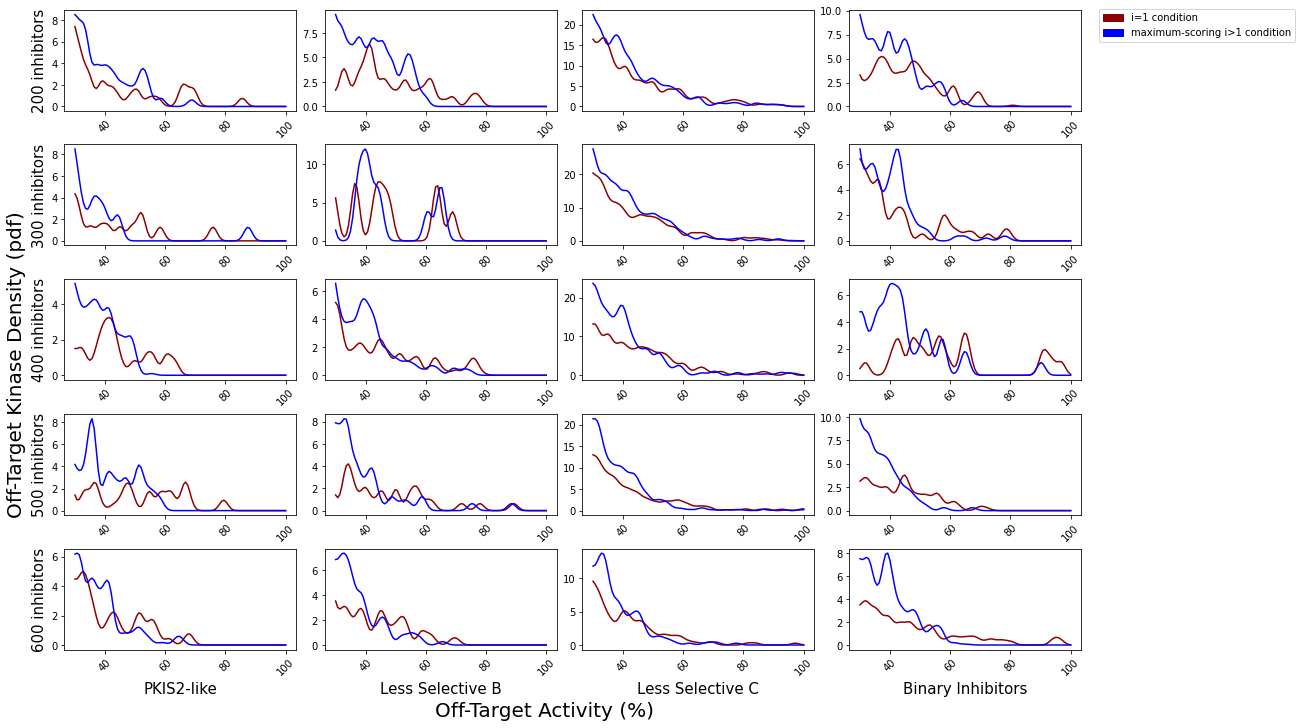

In [72]:
off_target_effects_700 = off_target_effects_700 #a reminder of the variable name

from scipy.stats import norm

#For each condition, get the off-targets and build plots for the actual changes in off-target effects

nrows = 5
ncols = 4

fig, axes = plt.subplots(nrows, ncols, figsize=(15,10),constrained_layout=True)

fig.supxlabel('Off-Target Activity (%)', fontsize=20)
fig.supylabel('Off-Target Kinase Density (pdf)', fontsize=20)

i1_patch = mpatches.Patch(color='darkred', label='i=1 condition')
max_patch = mpatches.Patch(color='b', label='maximum-scoring i>1 condition')

fig.legend(handles=[i1_patch,max_patch],bbox_to_anchor=(1.2, 1))

axes[4][0].set_xlabel('PKIS2-like',fontsize=15)
axes[4][1].set_xlabel('Less Selective B',fontsize=15)
axes[4][2].set_xlabel('Less Selective C',fontsize=15)
axes[4][3].set_xlabel('Binary Inhibitors',fontsize=15)

axes[0][0].set_ylabel('200 inhibitors',fontsize=15)
axes[1][0].set_ylabel('300 inhibitors',fontsize=15)
axes[2][0].set_ylabel('400 inhibitors',fontsize=15)
axes[3][0].set_ylabel('500 inhibitors',fontsize=15)
axes[4][0].set_ylabel('600 inhibitors',fontsize=15)

for row in range(0, nrows):
    
    for col in range(0, ncols):
        
        i1_scores = []
        i_maxx_scores = []
    
        num_r = 0
    
        for replicate in off_target_effects_700[row][col][0]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            i1_scores += vals
    
        for replicate in off_target_effects_700[row][col][1]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            i_maxx_scores += vals
            
        print('num replicates: ', (len(i1_scores)/99), 
              " represents improvement for these many kinases: ", (len(i1_scores)/99)/15)
        normfactor = (len(i1_scores)/99)/15
        
        #take avg_i1_200 and convert it into a density estimate
        x_d_1 = np.linspace(20, 100, 100)
        x_d_2 = np.linspace(20,100, 100)
        density = sum(norm(xi,scale=1.581).pdf(x_d_1)/normfactor for xi in i1_scores)
        density2 = sum(norm(xi,scale=1.581).pdf(x_d_2)/normfactor for xi in i_maxx_scores)
        
        axes[row][col].plot(x_d, density, color='darkred')
        axes[row][col].plot(x_d, density2, color='blue')
        axes[row][col].tick_params(axis='x', labelsize=10, rotation=45)
        
        #ylim = max(max(density),max(density2))
        
        #thresh1 = np.arange(0,ylim,0.01)
        #xlim = [30]*len(thresh1)
        #axes[row][col].plot(xlim,thresh1,'k--')
        
fig.savefig("012422_simulated-inhibitors-u=700-threshold-0.005.pdf", bbox_inches='tight',dpi=1000)

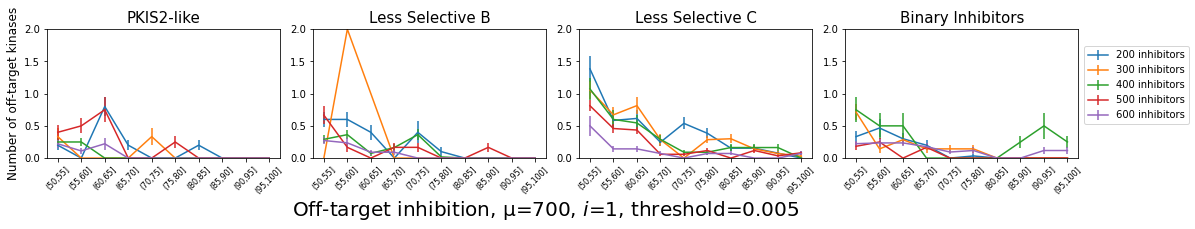

In [152]:
from scipy.stats import sem

#plot just the i=1 scores with SEM (not std) of the scores

off_target_effects_700 = off_target_effects_700 #a reminder of the variable name

nrows = 5
ncols = 4

fig, axes = plt.subplots(1, ncols, figsize=(15,3),constrained_layout=True)

axes[0].set_title('PKIS2-like',fontsize=15)
axes[1].set_title('Less Selective B',fontsize=15)
axes[2].set_title('Less Selective C',fontsize=15)
axes[3].set_title('Binary Inhibitors',fontsize=15)

fig.supxlabel('Off-target inhibition, μ=700, $\it{i}$=1, threshold=0.005', fontsize=20)
axes[0].set_ylabel('Number of off-target kinases', fontsize=12)

for row in range(0, nrows):
    
    for col in range(0, ncols):
        
        i1_700_binned = []
    
        for replicate in off_target_effects_700[row][col][0]:
            vals = (replicate[1:-1]).split(', ')
            vals = [float(x) for x in vals]
            bins = [0 for i in range(0,20)] #bin size=5 for the final off-target distribution
            for x in range(0, len(vals)): 
                temp = int(vals[x]/5)
                if temp < 20 and temp >= 0:
                    bins[temp] += 1.0
                elif temp >= 20:
                    bins[len(bins)-1] += 1.0
                else:
                    bins[0] += 1.0
            i1_700_binned.append(bins)
        
        avg_i1_700=list(np.average(i1_700_binned, axis=0))
        sem_i1_700=list(sem(i1_700_binned, axis=0))
    
        bin_max = ['0','(0,5)', '(5,10]', '(10,15]', '(15,20]', '(25,30]',
               '(30,35]', '(35,40]', '(40,45]', '(45,50]', '(50,55]',
               '(55,60]', '(60,65]', '(65,70]', '(70,75]', '(75,80]',
               '(80,85]', '(85,90]', '(90,95]', '(95,100]']
    
        #only plot from 20 upwards
        bin_max_700 = bin_max[10:]
        avg_i1_700 = avg_i1_700[10:]
        sem_i1_700 = sem_i1_700[10:]
    
        axes[col].errorbar(bin_max_700, avg_i1_700, yerr=sem_i1_700,xerr=None)
        axes[col].tick_params(axis='x', labelsize=8, rotation=45)
        axes[col].set_ylim([0,2])
        
fig.legend(labels=['200 inhibitors','300 inhibitors',
                   '400 inhibitors','500 inhibitors',
                   '600 inhibitors'],bbox_to_anchor=(1.1, 0.85))
    
fig.savefig("121921_PKIS2_JSD_700v200_best_i1_offtarget_profiles_u=700_threshold=0.005.pdf", bbox_inches='tight',dpi=500)